# Mobility data anlaysis (Matt)

In [1]:
# imports and setup
from   ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   scipy.optimize import curve_fit
from   scipy.stats import permutation_test
import seaborn as sns
from   sklearn.preprocessing import LabelBinarizer
import string
import warnings

# locations
data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
metadata_dir = os.path.join(data_dir, 'metadata')
fig_dir = os.path.join('..', 'figures')

conlit_file = 'CONLIT_CharData_AP_MW_12.csv.gz'
early_file  = 'EARLY_CharData_AP_MW_12.csv.gz'
all_file    = 'ALL_CharData_AP_MW_12.csv.gz'

conlit_meta_file = 'CONLIT_META.csv'
early_meta_file = 'EARLY_META.tsv'

# settings
vis_formats = [
    'png',
    'svg',
    #'eps'
]

## Load data

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

# read CONLIT
conlit = pd.read_csv(
    os.path.join(derived_dir, conlit_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit.replace([np.inf, -np.inf], np.nan, inplace=True)
conlit.rename(columns={'source':'collection'}, inplace=True)
conlit.loc[conlit.inf_gender=='she/her', ['inf_gender']] = 'she/her/hers'

# read EARLY
early = pd.read_csv(
    os.path.join(derived_dir, early_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
early.replace([np.inf, -np.inf], np.nan, inplace=True)
early.loc[early.inf_gender=='she/her', ['inf_gender']] = 'she/her/hers'

## Calculate new features

For narrative perspective, we set `first` if protagonist `char_id` is zero. See [BookNLP code](https://github.com/booknlp/booknlp/blob/2b42ccd40dc2c62097308398d4e08f91ecab4177/booknlp/english/name_coref.py#L339) for full details. In brief, BookNLP assigns all mentions of `I`, `me`, `myself`, and `my` *outside* of quotations to `char_id` zero, which is presumed to be the first-person narrator. If that `char_id` is then the most common one, it will be identified as the protagonist. We then infer that the book is narrated in the first person, otherwise not.

In [3]:
early['dist_miles_norm'] = early.dist_miles.div(early.Tokens)
early['dist_miles_norm_byCharacter'] = early.dist_miles.div(early.char_count)
early['perspective'] = early.char_id.apply(lambda x: 'first' if x==0 else 'other')
conlit['dist_miles_norm'] = conlit.dist_miles.div(conlit.Tokens)
conlit['dist_miles_norm_byCharacter'] = conlit.dist_miles.div(conlit.char_count)
conlit['perspective'] = conlit.char_id.apply(lambda x: 'first' if x==0 else 'other')

## Combine data

Combine EARLY and CONLIT, calculate integrated distance ranks, and write out combined data.

In [4]:
# combine data for easier plotting
data = pd.concat([conlit, early])
data['dist_miles_rank'] = data.dist_miles.rank()
data['non_gpe_total_rank'] = data.nongpe_places_total.rank()
data['gpe_total_rank'] = data.gpe_places_total.rank()

# write to disk
data.to_csv(os.path.join(derived_dir, all_file))

## Corpus stats and vis

In [5]:
# rename collections for better legibility
data.collection.replace(
    to_replace = {
        'conlit':'CONLIT',
        'chicago_1':'Chicago I',
        'chicago_2':'Chicago II',
        'wright':'Wright',
        'eaf':'EAF'
    },
    inplace=True
)

print(f"Volumes in corpus: {len(data)}")
display(data.collection.value_counts())

Volumes in corpus: 13383


collection
Chicago II    6481
CONLIT        2754
Chicago I     2608
Wright        1052
EAF            488
Name: count, dtype: int64

In [6]:
print(f"Volumes in EARLY: {len(data.loc[data.collection!='CONLIT'])}")

Volumes in EARLY: 10629


In [7]:
print(f"Earliest volume: {data.pub_date.min()}; latest volume: {data.pub_date.max()}")

Earliest volume: 1789; latest volume: 2021


In [8]:
print("Date ranges by subcorpus")
data[['collection', 'pub_date']].groupby('collection').describe()

Date ranges by subcorpus


pub_date                                                          \
              count         mean        std     min     25%     50%     75%   
collection                                                                    
CONLIT       2754.0  2013.319172   2.910859  2001.0  2012.0  2014.0  2015.0   
Chicago I    2608.0  1921.407209  16.567741  1880.0  1909.0  1924.0  1936.0   
Chicago II   6481.0  1982.770714  15.263748  1946.0  1974.0  1988.0  1995.0   
EAF           488.0  1835.625000  12.612075  1789.0  1831.0  1838.0  1845.0   
Wright       1052.0  1862.470532   7.850536  1837.0  1855.0  1863.0  1869.0   

                    
               max  
collection          
CONLIT      2021.0  
Chicago I   1945.0  
Chicago II  2000.0  
EAF         1850.0  
Wright      1875.0

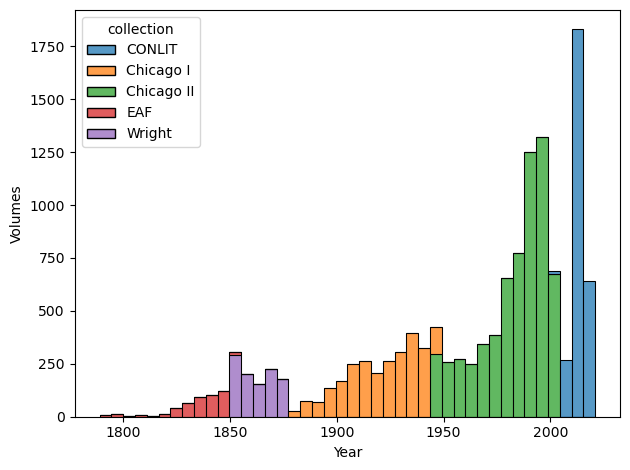

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.histplot(
        x='pub_date', 
        data=data, 
        hue='collection',
        multiple='stack',
        line_kws={'linewidth':0}
    )
    plt.xlabel('Year')
    plt.ylabel('Volumes')
    plt.tight_layout()
    for ext in vis_formats:
        plt.savefig(os.path.join(fig_dir, 'corpus_histogram.'+ext), dpi=300)
    plt.show()

# Feature differences by facet 

### CONLIT

In [10]:
def significance_label(pvalue, levels=[0.05, 0.01, 0.001]):
    if pvalue < levels[2]:
        return '***'
    elif pvalue < levels[1]:
        return '**'
    elif pvalue < levels[0]:
        return '*'
    else: 
        return ''

def diff_means(x, y, axis):
    return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)

def compare_facets(df, facets, cols_to_drop, statistic=diff_means):
    '''Compare statistic in numeric cols of df via permutation. Display results, return nothing.'''
    cols = df.select_dtypes(include='number').drop(columns=cols_to_drop).columns
    for facet in facets:
        print(f"\n==============\nFacet: {facet}\n==============")           
        df = df.dropna(subset=[facet])
        if facet != 'Category': # unless comparing FIC to NON, drop NON
            df = df.loc[df.Category=='FIC']
            
        if facet == 'inf_gender': # only keep she/her and he/him characters when comparing genders
            df = df.loc[df[facet].isin(set(['she/her/hers', 'he/him/his']))]
        elif facet == 'author_gender': # ditto M/F only for authors
            df = df.loc[df[facet].isin(set(['F', 'M']))]

        if df[facet].nunique() == 1:
            pass
        if df[facet].nunique() == 2:
            level1, level2 = df[facet].unique()
            data = (df.loc[df[facet]==level1, cols], df.loc[df[facet]==level2, cols])
            level_mean = np.mean(data[0], axis=0)
            other_mean = np.mean(data[1], axis=0)
            output = pd.DataFrame(level_mean, columns=[level1]).join(pd.DataFrame(other_mean, columns=[level2]))
            res = permutation_test(data, statistic, n_resamples=2500)
            output['diff'] = res.statistic
            output['p'] = res.pvalue
            output['sig'] = output['p'].apply(significance_label)
            display(output)            
        else:
            for level in df[facet].unique():
                data = (df.loc[df[facet]==level, cols], df.loc[~(df[facet]==level), cols])
                level_mean = np.mean(data[0], axis=0)
                other_mean = np.mean(data[1], axis=0)
                output = pd.DataFrame(level_mean, columns=[level]).join(pd.DataFrame(other_mean, columns=['others']))
                res = permutation_test(data, statistic, n_resamples=2500)
                output['diff'] = res.statistic
                output['p'] = res.pvalue
                output['sig'] = output['p'].apply(significance_label)
                display(output)

In [11]:
facet_by = ['Category', 'inf_gender', 'author_gender', 'perspective', 'Genre']
ignore_numeric_cols = ['char_id', 'char_rank', 'num_words']
compare_facets(conlit, facet_by, ignore_numeric_cols, diff_means)


Facet: Category


FIC            NON  \
char_count                             4201.894519    2884.367073   
num_gpe_places                           13.344881      35.776829   
num_nongpe_places                       123.875388     120.786585   
num_all_places                          136.805584     155.698780   
dist_miles                            38024.078670  131262.735676   
Tokens                               121620.681489  142400.906098   
num_gpe_places_norm                       0.000117       0.000263   
num_nongpe_places_norm                    0.001116       0.000970   
num_gpe_places_norm_byCharacter           0.003816       0.018413   
num_nongpe_places_norm_byCharacter        0.033306       0.046310   
char_count_norm                           0.036964       0.022761   
nongpe_places_total                     275.668046     241.345122   
gpe_places_total                         38.888831     126.523171   
ttr_nongpe                                0.483171       0.579897   
ttr_gpe                                   0.434065       0.391032   
avg_Distance_GPE                        868.661990    1042.778946   
non_gpe_ratio                            14.331291       3.989569   
avg_Distance_GPE_Tokens                   0.327338       0.914396   
deixis_count_perplace                     0.109243       0.038252   
semantic_dist_mean                        0.521991       0.504489   
semantic_dist_total                      91.591084      84.194248   
dist_miles_allChars                   91745.375475  294039.950514   
dist_miles_allChars_norm_Tokens           0.756511       1.936208   
num_gpe_places_allChars_norm_Tokens       0.000344       0.000679   
non_gpe_total_rank                     1493.716649    1103.398780   
dist_miles_rank                        1174.250776    1829.852439   
pub_date                               2013.463806    2012.978049   
Start_Finish_Miles                     1854.249567    1942.706982   
Start_Finish_Z                           -1.596047      -0.466106   
first_last_SemanticDist                   0.491751       0.449981   
hops                                     15.555326      60.750000   
dist_miles_norm                           0.327338       0.914396   
dist_miles_norm_byCharacter              10.135320      54.641669   

                                              diff         p  sig  
char_count                             1317.527446  0.000800  ***  
num_gpe_places                          -22.431948  0.000800  ***  
num_nongpe_places                         3.088802  0.322271       
num_all_places                          -18.893196  0.000800  ***  
dist_miles                           -93238.657006  0.000800  ***  
Tokens                               -20780.224608  0.000800  ***  
num_gpe_places_norm                      -0.000145  0.000800  ***  
num_nongpe_places_norm                    0.000146  0.000800  ***  
num_gpe_places_norm_byCharacter          -0.014597  0.000800  ***  
num_nongpe_places_norm_byCharacter       -0.013004  0.000800  ***  
char_count_norm                           0.014203  0.000800  ***  
nongpe_places_total                      34.322924  0.000800  ***  
gpe_places_total                        -87.634339  0.000800  ***  
ttr_nongpe                               -0.096726  0.000800  ***  
ttr_gpe                                   0.043033  0.000800  ***  
avg_Distance_GPE                       -174.116956  0.000800  ***  
non_gpe_ratio                            10.341721  0.000800  ***  
avg_Distance_GPE_Tokens                  -0.587058  0.000800  ***  
deixis_count_perplace                     0.070991  0.000800  ***  
semantic_dist_mean                        0.017502  0.000800  ***  
semantic_dist_total                       7.396837  0.004798   **  
dist_miles_allChars                 -202294.575039  0.000800  ***  
dist_miles_allChars_norm_Tokens          -1.179697  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      -0.000335  0.000800  ***  



Facet: inf_gender


she/her/hers     he/him/his  \
char_count                             3869.822581    4419.452542   
num_gpe_places                           12.211022      13.991525   
num_nongpe_places                       119.575269     126.536441   
num_all_places                          131.372312     140.116949   
dist_miles                            35721.668613   39372.905574   
Tokens                               116767.427419  124867.428814   
num_gpe_places_norm                       0.000112       0.000120   
num_nongpe_places_norm                    0.001117       0.001113   
num_gpe_places_norm_byCharacter           0.003544       0.003949   
num_nongpe_places_norm_byCharacter        0.033896       0.032826   
char_count_norm                           0.035634       0.037855   
nongpe_places_total                     267.598118     280.738136   
gpe_places_total                         36.295699      40.450000   
ttr_nongpe                                0.475910       0.487394   
ttr_gpe                                   0.431249       0.435698   
avg_Distance_GPE                        867.815240     866.634166   
non_gpe_ratio                            14.889263      14.030061   
avg_Distance_GPE_Tokens                   0.326169       0.326810   
deixis_count_perplace                     0.106820       0.110842   
semantic_dist_mean                        0.518529       0.523879   
semantic_dist_total                      88.455784      93.477219   
dist_miles_allChars                   89019.272033   93565.844858   
dist_miles_allChars_norm_Tokens           0.766624       0.748887   
num_gpe_places_allChars_norm_Tokens       0.000344       0.000343   
non_gpe_total_rank                     1500.219086    1488.658475   
dist_miles_rank                        1142.452957    1191.646610   
pub_date                               2013.611559    2013.386441   
Start_Finish_Miles                     1851.254474    1849.394892   
Start_Finish_Z                           -4.621444       0.294762   
first_last_SemanticDist                   0.486589       0.494410   
hops                                     14.306452      16.324576   
dist_miles_norm                           0.326169       0.326810   
dist_miles_norm_byCharacter               9.722169      10.281272   

                                             diff         p  sig  
char_count                          -5.496300e+02  0.000800  ***  
num_gpe_places                      -1.780504e+00  0.000800  ***  
num_nongpe_places                   -6.961172e+00  0.013595    *  
num_all_places                      -8.744637e+00  0.005598   **  
dist_miles                          -3.651237e+03  0.119152       
Tokens                              -8.100001e+03  0.003998   **  
num_gpe_places_norm                 -7.332272e-06  0.086365       
num_nongpe_places_norm               3.798993e-06  0.859656       
num_gpe_places_norm_byCharacter     -4.059017e-04  0.003199   **  
num_nongpe_places_norm_byCharacter   1.070398e-03  0.067173       
char_count_norm                     -2.221123e-03  0.005598   **  
nongpe_places_total                 -1.314002e+01  0.072771       
gpe_places_total                    -4.154301e+00  0.027989    *  
ttr_nongpe                          -1.148343e-02  0.016793    *  
ttr_gpe                             -4.449416e-03  0.672531       
avg_Distance_GPE                     1.181074e+00  0.971611       
non_gpe_ratio                        8.592020e-01  0.217513       
avg_Distance_GPE_Tokens             -6.406348e-04  0.988405       
deixis_count_perplace               -4.021925e-03  0.177529       
semantic_dist_mean                  -5.350181e-03  0.020792    *  
semantic_dist_total                 -5.021436e+00  0.037585    *  
dist_miles_allChars                 -4.546573e+03  0.379048       
dist_miles_allChars_norm_Tokens      1.773683e-02  0.648541       
num_gpe_places_allChars_norm_Tokens  6.786817e-07  0.939624       
non_gpe_total_ra


Facet: author_gender


F              M  \
char_count                             4644.710037    3643.078571   
num_gpe_places                           11.391264      15.770238   
num_nongpe_places                       122.588290     125.415476   
num_all_places                          133.612454     140.714286   
dist_miles                            31076.145753   46890.310138   
Tokens                               113823.980483  132061.921429   
num_gpe_places_norm                       0.000106       0.000130   
num_nongpe_places_norm                    0.001150       0.001068   
num_gpe_places_norm_byCharacter           0.002984       0.004834   
num_nongpe_places_norm_byCharacter        0.030522       0.036738   
char_count_norm                           0.042380       0.030002   
nongpe_places_total                     288.028810     259.541667   
gpe_places_total                         34.311338      44.729762   
ttr_nongpe                                0.453913       0.520544   
ttr_gpe                                   0.424515       0.445455   
avg_Distance_GPE                        800.361704     954.472436   
non_gpe_ratio                            16.432063      11.728380   
avg_Distance_GPE_Tokens                   0.285660       0.379746   
deixis_count_perplace                     0.115910       0.100811   
semantic_dist_mean                        0.512836       0.533583   
semantic_dist_total                      92.078374      90.848095   
dist_miles_allChars                   73760.116134  115293.773435   
dist_miles_allChars_norm_Tokens           0.650001       0.893923   
num_gpe_places_allChars_norm_Tokens       0.000310       0.000386   
non_gpe_total_rank                     1630.141264    1313.042857   
dist_miles_rank                        1096.818773    1270.916667   
pub_date                               2013.822491    2013.020238   
Start_Finish_Miles                     1780.889461    1939.350581   
Start_Finish_Z                           -2.019468      -1.097272   
first_last_SemanticDist                   0.488950       0.496549   
hops                                     13.330855      18.389286   
dist_miles_norm                           0.285660       0.379746   
dist_miles_norm_byCharacter               7.825254      12.954121   

                                             diff         p  sig  
char_count                            1001.631466  0.000800  ***  
num_gpe_places                          -4.378974  0.000800  ***  
num_nongpe_places                       -2.827186  0.300680       
num_all_places                          -7.101832  0.024790    *  
dist_miles                          -15814.164384  0.000800  ***  
Tokens                              -18237.940945  0.000800  ***  
num_gpe_places_norm                     -0.000024  0.000800  ***  
num_nongpe_places_norm                   0.000081  0.000800  ***  
num_gpe_places_norm_byCharacter         -0.001850  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.006216  0.000800  ***  
char_count_norm                          0.012379  0.000800  ***  
nongpe_places_total                     28.487144  0.000800  ***  
gpe_places_total                       -10.418424  0.000800  ***  
ttr_nongpe                              -0.066631  0.000800  ***  
ttr_gpe                                 -0.020940  0.027989    *  
avg_Distance_GPE                      -154.110733  0.000800  ***  
non_gpe_ratio                            4.703683  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.094085  0.000800  ***  
deixis_count_perplace                    0.015099  0.000800  ***  
semantic_dist_mean                      -0.020747  0.000800  ***  
semantic_dist_total                      1.230279  0.632547       
dist_miles_allChars                 -41533.657302  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.243922  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000076  0.000800  ***  
non_gpe_total_rank         


Facet: perspective


other          first  \
char_count                             3297.110643    5097.141675   
num_gpe_places                           11.762908      14.830403   
num_nongpe_places                       107.978925     139.381593   
num_all_places                          119.384615     153.744571   
dist_miles                            31431.100424   44465.024864   
Tokens                               130355.756586  113442.610134   
num_gpe_places_norm                       0.000095       0.000138   
num_nongpe_places_norm                    0.000914       0.001310   
num_gpe_places_norm_byCharacter           0.003987       0.003607   
num_nongpe_places_norm_byCharacter        0.035071       0.031458   
char_count_norm                           0.027834       0.045903   
nongpe_places_total                     227.099052     323.078594   
gpe_places_total                         32.599579      45.041365   
ttr_nongpe                                0.508191       0.458526   
ttr_gpe                                   0.450853       0.416858   
avg_Distance_GPE                        846.395840     889.055209   
non_gpe_ratio                            14.708834      14.017198   
avg_Distance_GPE_Tokens                   0.247911       0.404436   
deixis_count_perplace                     0.101950       0.116493   
semantic_dist_mean                        0.527817       0.516157   
semantic_dist_total                      77.351407     105.462507   
dist_miles_allChars                   93682.158235   90287.783331   
dist_miles_allChars_norm_Tokens           0.713368       0.799701   
num_gpe_places_allChars_norm_Tokens       0.000340       0.000347   
non_gpe_total_rank                     1168.925184    1807.319545   
dist_miles_rank                        1033.741834    1309.954498   
pub_date                               2013.358272    2013.581179   
Start_Finish_Miles                     1813.183818    1886.846023   
Start_Finish_Z                           -1.794261      -1.431164   
first_last_SemanticDist                   0.491812       0.492714   
hops                                     12.728135      18.316443   
dist_miles_norm                           0.247911       0.404436   
dist_miles_norm_byCharacter               9.846532      10.296874   

                                             diff         p  sig  
char_count                           -1800.031033  0.000800  ***  
num_gpe_places                          -3.067495  0.000800  ***  
num_nongpe_places                      -31.402667  0.000800  ***  
num_all_places                         -34.359955  0.000800  ***  
dist_miles                          -13033.924440  0.000800  ***  
Tokens                               16913.146451  0.000800  ***  
num_gpe_places_norm                     -0.000043  0.000800  ***  
num_nongpe_places_norm                  -0.000395  0.000800  ***  
num_gpe_places_norm_byCharacter          0.000380  0.003998   **  
num_nongpe_places_norm_byCharacter       0.003614  0.000800  ***  
char_count_norm                         -0.018069  0.000800  ***  
nongpe_places_total                    -95.979542  0.000800  ***  
gpe_places_total                       -12.441787  0.000800  ***  
ttr_nongpe                               0.049665  0.000800  ***  
ttr_gpe                                  0.033995  0.000800  ***  
avg_Distance_GPE                       -42.659369  0.195122       
non_gpe_ratio                            0.691636  0.328669       
avg_Distance_GPE_Tokens                 -0.156525  0.000800  ***  
deixis_count_perplace                   -0.014543  0.000800  ***  
semantic_dist_mean                       0.011660  0.000800  ***  
semantic_dist_total                    -28.111100  0.000800  ***  
dist_miles_allChars                   3394.374904  0.501399       
dist_miles_allChars_norm_Tokens         -0.086332  0.030388    *  
num_gpe_places_allChars_norm_Tokens     -0.000007  0.499000       
non_gpe_total_rank     


Facet: Genre


YA         others  \
char_count                             5656.602273    4058.811494   
num_gpe_places                           11.539773      13.490230   
num_nongpe_places                       130.767045     123.125862   
num_all_places                          141.875000     136.205172   
dist_miles                            28865.073812   38934.218595   
Tokens                               106003.238636  123419.567241   
num_gpe_places_norm                       0.000114       0.000117   
num_nongpe_places_norm                    0.001257       0.001099   
num_gpe_places_norm_byCharacter           0.002366       0.003940   
num_nongpe_places_norm_byCharacter        0.024401       0.034142   
char_count_norm                           0.053501       0.035279   
nongpe_places_total                     330.079545     270.022989   
gpe_places_total                         36.119318      39.158046   
ttr_nongpe                                0.414910       0.490025   
ttr_gpe                                   0.398016       0.437305   
avg_Distance_GPE                        728.659019     882.012674   
non_gpe_ratio                            16.968793      14.096091   
avg_Distance_GPE_Tokens                   0.288061       0.330838   
deixis_count_perplace                     0.131660       0.107027   
semantic_dist_mean                        0.501987       0.523949   
semantic_dist_total                     101.184966      90.563320   
dist_miles_allChars                   60020.694978   95200.581799   
dist_miles_allChars_norm_Tokens           0.593781       0.773443   
num_gpe_places_allChars_norm_Tokens       0.000301       0.000348   
non_gpe_total_rank                     1950.892045    1444.615517   
dist_miles_rank                        1153.289773    1175.154023   
pub_date                               2014.926136    2013.323563   
Start_Finish_Miles                     1436.774770    1892.194936   
Start_Finish_Z                           -0.752889      -1.696718   
first_last_SemanticDist                   0.518673       0.489487   
hops                                     13.693182      15.736207   
dist_miles_norm                           0.288061       0.330838   
dist_miles_norm_byCharacter               6.043016      10.481532   

                                             diff         p  sig  
char_count                            1597.790778  0.000800  ***  
num_gpe_places                          -1.950457  0.011995    *  
num_nongpe_places                        7.641183  0.126349       
num_all_places                           5.669828  0.291084       
dist_miles                          -10069.144784  0.006397   **  
Tokens                              -17416.328605  0.000800  ***  
num_gpe_places_norm                     -0.000004  0.622151       
num_nongpe_places_norm                   0.000158  0.001599   **  
num_gpe_places_norm_byCharacter         -0.001573  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.009741  0.000800  ***  
char_count_norm                          0.018221  0.000800  ***  
nongpe_places_total                     60.056557  0.000800  ***  
gpe_places_total                        -3.038728  0.305478       
ttr_nongpe                              -0.075115  0.000800  ***  
ttr_gpe                                 -0.039289  0.015994    *  
avg_Distance_GPE                      -153.353655  0.003199   **  
non_gpe_ratio                            2.872702  0.031987    *  
avg_Distance_GPE_Tokens                 -0.042777  0.207917       
deixis_count_perplace                    0.024632  0.000800  ***  
semantic_dist_mean                      -0.021962  0.000800  ***  
semantic_dist_total                     10.621647  0.015994    *  
dist_miles_allChars                 -35179.886820  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.179663  0.004798   **  
num_gpe_places_allChars_norm_Tokens     -0.000046  0.004798   **  
non_gpe_total_rank        

SF         others  \
char_count                             3816.963303    4255.474676   
num_gpe_places                           12.559633      13.407538   
num_nongpe_places                       114.935780     124.969376   
num_all_places                          126.899083     137.987633   
dist_miles                            30941.681274   38916.670688   
Tokens                               144582.059633  118897.366313   
num_gpe_places_norm                       0.000097       0.000120   
num_nongpe_places_norm                    0.000889       0.001143   
num_gpe_places_norm_byCharacter           0.003720       0.003805   
num_nongpe_places_norm_byCharacter        0.031726       0.033443   
char_count_norm                           0.029121       0.037959   
nongpe_places_total                     232.545872     281.059482   
gpe_places_total                         34.119266      39.489988   
ttr_nongpe                                0.528479       0.477302   
ttr_gpe                                   0.454952       0.430967   
avg_Distance_GPE                        800.336282     876.603492   
non_gpe_ratio                            13.996746      14.407651   
avg_Distance_GPE_Tokens                   0.240555       0.337995   
deixis_count_perplace                     0.112552       0.108871   
semantic_dist_mean                        0.547676       0.518627   
semantic_dist_total                      82.904059      92.647612   
dist_miles_allChars                   75814.526143   94043.043549   
dist_miles_allChars_norm_Tokens           0.552357       0.783206   
num_gpe_places_allChars_norm_Tokens       0.000277       0.000352   
non_gpe_total_rank                     1109.573394    1540.106596   
dist_miles_rank                         955.743119    1201.057126   
pub_date                               2012.940367    2013.538869   
Start_Finish_Miles                     2269.024192    1796.610291   
Start_Finish_Z                           -0.685420      -1.724061   
first_last_SemanticDist                   0.533554       0.487462   
hops                                     11.169725      16.110718   
dist_miles_norm                           0.240555       0.337995   
dist_miles_norm_byCharacter               8.563491      10.267724   

                                             diff         p  sig  
char_count                            -438.511373  0.010396    *  
num_gpe_places                          -0.847905  0.243103       
num_nongpe_places                      -10.033596  0.016793    *  
num_all_places                         -11.088550  0.015994    *  
dist_miles                           -7974.989414  0.018393    *  
Tokens                               25684.693320  0.000800  ***  
num_gpe_places_norm                     -0.000023  0.000800  ***  
num_nongpe_places_norm                  -0.000253  0.000800  ***  
num_gpe_places_norm_byCharacter         -0.000084  0.683727       
num_nongpe_places_norm_byCharacter      -0.001716  0.057577       
char_count_norm                         -0.008838  0.000800  ***  
nongpe_places_total                    -48.513610  0.000800  ***  
gpe_places_total                        -5.370722  0.051180       
ttr_nongpe                               0.051176  0.000800  ***  
ttr_gpe                                  0.023985  0.111955       
avg_Distance_GPE                       -76.267210  0.131947       
non_gpe_ratio                           -0.410905  0.763695       
avg_Distance_GPE_Tokens                 -0.097441  0.000800  ***  
deixis_count_perplace                    0.003681  0.424630       
semantic_dist_mean                       0.029049  0.000800  ***  
semantic_dist_total                     -9.743553  0.010396    *  
dist_miles_allChars                 -18228.517406  0.015994    *  
dist_miles_allChars_norm_Tokens         -0.230849  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000075  0.000800  ***  
non_gpe_total_rank        

BS         others  \
char_count                             4732.879032    4127.182254   
num_gpe_places                           17.459677      12.694245   
num_nongpe_places                       143.322581     120.929257   
num_all_places                          160.282258     133.223621   
dist_miles                            48957.187351   36381.541297   
Tokens                               155174.580645  116860.504197   
num_gpe_places_norm                       0.000125       0.000116   
num_nongpe_places_norm                    0.001016       0.001129   
num_gpe_places_norm_byCharacter           0.004558       0.003682   
num_nongpe_places_norm_byCharacter        0.034952       0.032994   
char_count_norm                           0.031016       0.037836   
nongpe_places_total                     311.072581     270.256595   
gpe_places_total                         50.020161      37.222422   
ttr_nongpe                                0.499054       0.480757   
ttr_gpe                                   0.439863       0.432779   
avg_Distance_GPE                        938.972800     857.362581   
non_gpe_ratio                            10.622966      14.925754   
avg_Distance_GPE_Tokens                   0.339223       0.325078   
deixis_count_perplace                     0.108939       0.109342   
semantic_dist_mean                        0.519814       0.522247   
semantic_dist_total                     105.492714      89.464351   
dist_miles_allChars                  126305.203528   86863.887393   
dist_miles_allChars_norm_Tokens           0.850054       0.743096   
num_gpe_places_allChars_norm_Tokens       0.000395       0.000336   
non_gpe_total_rank                     1332.032258    1514.774580   
dist_miles_rank                        1273.657258    1158.201439   
pub_date                               2011.790323    2013.720624   
Start_Finish_Miles                     1868.137934    1847.717830   
Start_Finish_Z                           -1.000769      -1.701696   
first_last_SemanticDist                   0.480895       0.494057   
hops                                     21.068548      14.727818   
dist_miles_norm                           0.339223       0.325078   
dist_miles_norm_byCharacter              11.636333       9.841502   

                                             diff         p  sig  
char_count                             605.696778  0.002399   **  
num_gpe_places                           4.765433  0.000800  ***  
num_nongpe_places                       22.393324  0.000800  ***  
num_all_places                          27.058637  0.000800  ***  
dist_miles                           12575.646054  0.002399   **  
Tokens                               38314.076449  0.000800  ***  
num_gpe_places_norm                      0.000009  0.157537       
num_nongpe_places_norm                  -0.000113  0.001599   **  
num_gpe_places_norm_byCharacter          0.000876  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.001958  0.026389    *  
char_count_norm                         -0.006820  0.000800  ***  
nongpe_places_total                     40.815986  0.000800  ***  
gpe_places_total                        12.797739  0.000800  ***  
ttr_nongpe                               0.018297  0.003199   **  
ttr_gpe                                  0.007085  0.611755       
avg_Distance_GPE                        81.610219  0.093563       
non_gpe_ratio                           -4.302788  0.000800  ***  
avg_Distance_GPE_Tokens                  0.014146  0.600560       
deixis_count_perplace                   -0.000403  0.907637       
semantic_dist_mean                      -0.002432  0.456617       
semantic_dist_total                     16.028364  0.000800  ***  
dist_miles_allChars                  39441.316135  0.000800  ***  
dist_miles_allChars_norm_Tokens          0.106958  0.078369       
num_gpe_places_allChars_norm_Tokens      0.000059  0.000800  ***  
non_gpe_total_rank        

NYT         others  \
char_count                             3719.703349    4341.160214   
num_gpe_places                           16.351675      12.462617   
num_nongpe_places                       129.624402     122.210280   
num_all_places                          145.581340     134.255007   
dist_miles                            52104.402460   34076.203684   
Tokens                               118268.789474  122810.589453   
num_gpe_places_norm                       0.000150       0.000108   
num_nongpe_places_norm                    0.001194       0.001092   
num_gpe_places_norm_byCharacter           0.004899       0.003487   
num_nongpe_places_norm_byCharacter        0.037954       0.031934   
char_count_norm                           0.032846       0.038099   
nongpe_places_total                     282.799043     273.514019   
gpe_places_total                         48.894737      36.084112   
ttr_nongpe                                0.494136       0.480052   
ttr_gpe                                   0.427841       0.435329   
avg_Distance_GPE                        962.235994     841.609742   
non_gpe_ratio                            12.343310      14.931847   
avg_Distance_GPE_Tokens                   0.460166       0.289725   
deixis_count_perplace                     0.092939       0.113853   
semantic_dist_mean                        0.530297       0.519598   
semantic_dist_total                      96.897805      90.043690   
dist_miles_allChars                  122780.156301   83371.528246   
dist_miles_allChars_norm_Tokens           1.065603       0.670811   
num_gpe_places_allChars_norm_Tokens       0.000433       0.000318   
non_gpe_total_rank                     1513.921053    1484.759012   
dist_miles_rank                        1416.016746    1105.375167   
pub_date                               2014.949761    2013.058077   
Start_Finish_Miles                     1973.131090    1816.103306   
Start_Finish_Z                           -1.556370      -1.624572   
first_last_SemanticDist                   0.502103       0.489446   
hops                                     21.440191      13.904539   
dist_miles_norm                           0.460166       0.289725   
dist_miles_norm_byCharacter              14.317249       8.889737   

                                             diff         p  sig  
char_count                            -621.456864  0.000800  ***  
num_gpe_places                           3.889058  0.000800  ***  
num_nongpe_places                        7.414122  0.023990    *  
num_all_places                          11.326333  0.001599   **  
dist_miles                           18028.198776  0.000800  ***  
Tokens                               -4541.799979  0.151939       
num_gpe_places_norm                      0.000042  0.000800  ***  
num_nongpe_places_norm                   0.000102  0.000800  ***  
num_gpe_places_norm_byCharacter          0.001412  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.006020  0.000800  ***  
char_count_norm                         -0.005253  0.000800  ***  
nongpe_places_total                      9.285024  0.307077       
gpe_places_total                        12.810625  0.000800  ***  
ttr_nongpe                               0.014084  0.011196    *  
ttr_gpe                                 -0.007488  0.520592       
avg_Distance_GPE                       120.626252  0.005598   **  
non_gpe_ratio                           -2.588536  0.001599   **  
avg_Distance_GPE_Tokens                  0.170441  0.000800  ***  
deixis_count_perplace                   -0.020914  0.000800  ***  
semantic_dist_mean                       0.010699  0.000800  ***  
semantic_dist_total                      6.854115  0.014394    *  
dist_miles_allChars                  39408.628055  0.000800  ***  
dist_miles_allChars_norm_Tokens          0.394792  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      0.000114  0.000800  ***  
non_gpe_total_rank       

MY         others  \
char_count                             4094.965217    4220.671412   
num_gpe_places                           13.247826      13.319692   
num_nongpe_places                       132.034783     122.708185   
num_all_places                          144.900000     135.610913   
dist_miles                            33428.516919   38634.184137   
Tokens                               124692.878261  121427.790629   
num_gpe_places_norm                       0.000109       0.000118   
num_nongpe_places_norm                    0.001111       0.001114   
num_gpe_places_norm_byCharacter           0.003719       0.003805   
num_nongpe_places_norm_byCharacter        0.034123       0.033128   
char_count_norm                           0.034449       0.037295   
nongpe_places_total                     289.978261     273.569988   
gpe_places_total                         34.834783      39.430605   
ttr_nongpe                                0.486349       0.482685   
ttr_gpe                                   0.447760       0.431777   
avg_Distance_GPE                        952.087061     856.444849   
non_gpe_ratio                            12.975515      14.551581   
avg_Distance_GPE_Tokens                   0.272269       0.334362   
deixis_count_perplace                     0.116867       0.108257   
semantic_dist_mean                        0.518997       0.522332   
semantic_dist_total                      97.120213      90.777628   
dist_miles_allChars                   88860.758443   92393.048757   
dist_miles_allChars_norm_Tokens           0.694281       0.765488   
num_gpe_places_allChars_norm_Tokens       0.000342       0.000344   
non_gpe_total_rank                     1493.726087    1490.765718   
dist_miles_rank                        1186.100000    1171.378410   
pub_date                               2013.965217    2013.403321   
Start_Finish_Miles                     1837.361257    1852.134317   
Start_Finish_Z                           -3.211927      -1.385717   
first_last_SemanticDist                   0.487467       0.492974   
hops                                     14.786957      15.652432   
dist_miles_norm                           0.272269       0.334362   
dist_miles_norm_byCharacter               9.114243      10.204721   

                                            diff         p sig  
char_count                           -125.706194  0.484606      
num_gpe_places                         -0.071865  0.939624      
num_nongpe_places                       9.326598  0.025590   *  
num_all_places                          9.289087  0.043982   *  
dist_miles                          -5205.667218  0.151140      
Tokens                               3265.087632  0.423830      
num_gpe_places_norm                    -0.000010  0.134346      
num_nongpe_places_norm                 -0.000003  0.947621      
num_gpe_places_norm_byCharacter        -0.000086  0.690124      
num_nongpe_places_norm_byCharacter      0.000995  0.251100      
char_count_norm                        -0.002846  0.023191   *  
nongpe_places_total                    16.408273  0.155938      
gpe_places_total                       -4.595822  0.086365      
ttr_nongpe                              0.003664  0.619752      
ttr_gpe                                 0.015983  0.277489      
avg_Distance_GPE                       95.642212  0.067973      
non_gpe_ratio                          -1.576065  0.115154      
avg_Distance_GPE_Tokens                -0.062094  0.038385   *  
deixis_count_perplace                   0.008610  0.043982   *  
semantic_dist_mean                     -0.003336  0.309476      
semantic_dist_total                     6.342584  0.085566      
dist_miles_allChars                 -3532.290314  0.670132      
dist_miles_allChars_norm_Tokens        -0.071207  0.224710      
num_gpe_places_allChars_norm_Tokens    -0.000002  0.898840      
non_gpe_total_rank                      2.960369  0.957217      
dist_miles_

ROM         others  \
char_count                             5964.347826    3992.553540   
num_gpe_places                            7.613527      14.001170   
num_nongpe_places                       108.797101     125.648332   
num_all_places                          116.198068     139.212405   
dist_miles                            20892.495650   40082.531742   
Tokens                               103463.314010  124043.131071   
num_gpe_places_norm                       0.000075       0.000122   
num_nongpe_places_norm                    0.001099       0.001116   
num_gpe_places_norm_byCharacter           0.001397       0.004085   
num_nongpe_places_norm_byCharacter        0.019868       0.034868   
char_count_norm                           0.058578       0.034334   
nongpe_places_total                     272.004831     275.967817   
gpe_places_total                         24.830918      40.580456   
ttr_nongpe                                0.420695       0.490687   
ttr_gpe                                   0.392168       0.438725   
avg_Distance_GPE                        660.077117     893.101274   
non_gpe_ratio                            20.492306      13.650819   
avg_Distance_GPE_Tokens                   0.195351       0.342843   
deixis_count_perplace                     0.147570       0.104653   
semantic_dist_mean                        0.483912       0.526537   
semantic_dist_total                      77.529356      93.235900   
dist_miles_allChars                   43630.213766   97823.990870   
dist_miles_allChars_norm_Tokens           0.400745       0.800084   
num_gpe_places_allChars_norm_Tokens       0.000201       0.000361   
non_gpe_total_rank                     1692.657005    1466.710357   
dist_miles_rank                         898.826087    1206.372147   
pub_date                               2014.386473    2013.359860   
Start_Finish_Miles                     1603.955196    1880.206449   
Start_Finish_Z                           -1.235037      -1.654495   
first_last_SemanticDist                   0.455287       0.496621   
hops                                      8.956522      16.346987   
dist_miles_norm                           0.195351       0.342843   
dist_miles_norm_byCharacter               3.564008      10.862309   

                                             diff         p  sig  
char_count                            1971.794286  0.000800  ***  
num_gpe_places                          -6.387644  0.000800  ***  
num_nongpe_places                      -16.851231  0.000800  ***  
num_all_places                         -23.014337  0.000800  ***  
dist_miles                          -19190.036092  0.000800  ***  
Tokens                              -20579.817061  0.000800  ***  
num_gpe_places_norm                     -0.000047  0.000800  ***  
num_nongpe_places_norm                  -0.000017  0.671731       
num_gpe_places_norm_byCharacter         -0.002688  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.015001  0.000800  ***  
char_count_norm                          0.024244  0.000800  ***  
nongpe_places_total                     -3.962987  0.757297       
gpe_places_total                       -15.749539  0.000800  ***  
ttr_nongpe                              -0.069992  0.000800  ***  
ttr_gpe                                 -0.046557  0.004798   **  
avg_Distance_GPE                      -233.024156  0.000800  ***  
non_gpe_ratio                            6.841487  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.147492  0.000800  ***  
deixis_count_perplace                    0.042917  0.000800  ***  
semantic_dist_mean                      -0.042626  0.000800  ***  
semantic_dist_total                    -15.706545  0.000800  ***  
dist_miles_allChars                 -54193.777104  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.399338  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000160  0.000800  ***  
non_gpe_total_rank       

PW         others  \
char_count                             3185.085938    4362.959036   
num_gpe_places                           14.812500      13.079518   
num_nongpe_places                       121.613281     124.169277   
num_all_places                          135.976562     136.841566   
dist_miles                            49134.962572   36293.519836   
Tokens                               122486.812500  121716.863253   
num_gpe_places_norm                       0.000134       0.000114   
num_nongpe_places_norm                    0.001108       0.001115   
num_gpe_places_norm_byCharacter           0.005177       0.003582   
num_nongpe_places_norm_byCharacter        0.042256       0.031858   
char_count_norm                           0.027561       0.038402   
nongpe_places_total                     259.597656     277.998193   
gpe_places_total                         42.367188      38.340964   
ttr_nongpe                                0.509417       0.479070   
ttr_gpe                                   0.462003       0.429330   
avg_Distance_GPE                       1021.589771     844.228348   
non_gpe_ratio                            12.142340      14.706934   
avg_Distance_GPE_Tokens                   0.442658       0.309058   
deixis_count_perplace                     0.087726       0.112616   
semantic_dist_mean                        0.531394       0.520473   
semantic_dist_total                      89.547556      91.846118   
dist_miles_allChars                  121557.580231   87405.972353   
dist_miles_allChars_norm_Tokens           1.010014       0.717912   
num_gpe_places_allChars_norm_Tokens       0.000396       0.000335   
non_gpe_total_rank                     1368.582031    1510.018675   
dist_miles_rank                        1325.539062    1149.643976   
pub_date                               2010.671875    2013.902410   
Start_Finish_Miles                     2152.926079    1803.700284   
Start_Finish_Z                           -0.500114      -1.782177   
first_last_SemanticDist                   0.487425       0.493033   
hops                                     17.578125      15.235542   
dist_miles_norm                           0.442658       0.309058   
dist_miles_norm_byCharacter              15.056938       9.305337   

                                             diff         p  sig  
char_count                           -1177.873099  0.000800  ***  
num_gpe_places                           1.732982  0.018393    *  
num_nongpe_places                       -2.555996  0.518992       
num_all_places                          -0.865004  0.854058       
dist_miles                           12841.442736  0.001599   **  
Tokens                                 769.949247  0.863655       
num_gpe_places_norm                      0.000020  0.001599   **  
num_nongpe_places_norm                  -0.000007  0.834866       
num_gpe_places_norm_byCharacter          0.001595  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.010398  0.000800  ***  
char_count_norm                         -0.010840  0.000800  ***  
nongpe_places_total                    -18.400537  0.076769       
gpe_places_total                         4.026224  0.123151       
ttr_nongpe                               0.030347  0.000800  ***  
ttr_gpe                                  0.032673  0.015194    *  
avg_Distance_GPE                       177.361423  0.000800  ***  
non_gpe_ratio                           -2.564594  0.005598   **  
avg_Distance_GPE_Tokens                  0.133599  0.000800  ***  
deixis_count_perplace                   -0.024889  0.000800  ***  
semantic_dist_mean                       0.010921  0.002399   **  
semantic_dist_total                     -2.298562  0.503798       
dist_miles_allChars                  34151.607877  0.000800  ***  
dist_miles_allChars_norm_Tokens          0.292102  0.000800  ***  
num_gpe_places_allChars_norm_Tokens      0.000061  0.000800  ***  
non_gpe_total_rank        

MID         others  \
char_count                            3127.607362    4305.815174   
num_gpe_places                           7.085890      13.889903   
num_nongpe_places                       94.687117     126.537365   
num_all_places                         101.472393     140.003993   
dist_miles                           15259.970781   40124.596754   
Tokens                               85022.184049  125241.301198   
num_gpe_places_norm                      0.000089       0.000120   
num_nongpe_places_norm                   0.001237       0.001102   
num_gpe_places_norm_byCharacter          0.002427       0.003922   
num_nongpe_places_norm_byCharacter       0.031779       0.033384   
char_count_norm                          0.039947       0.036675   
nongpe_places_total                    210.625767     281.575585   
gpe_places_total                        23.656442      40.294353   
ttr_nongpe                               0.477091       0.483686   
ttr_gpe                                  0.437854       0.433309   
avg_Distance_GPE                       662.612725     887.016638   
non_gpe_ratio                           21.406663      13.740634   
avg_Distance_GPE_Tokens                  0.186262       0.339987   
deixis_count_perplace                    0.097802       0.110358   
semantic_dist_mean                       0.528373       0.521333   
semantic_dist_total                     70.743655      93.472627   
dist_miles_allChars                  36119.512830   97162.107276   
dist_miles_allChars_norm_Tokens          0.416810       0.788566   
num_gpe_places_allChars_norm_Tokens      0.000271       0.000350   
non_gpe_total_rank                    1621.392638    1479.007986   
dist_miles_rank                        800.343558    1207.810040   
pub_date                              2013.907975    2013.430120   
Start_Finish_Miles                    1251.190307    1906.073889   
Start_Finish_Z                          -4.784675      -1.320166   
first_last_SemanticDist                  0.460953       0.494817   
hops                                     6.159509      16.421563   
dist_miles_norm                          0.186262       0.339987   
dist_miles_norm_byCharacter              4.981604      10.547310   

                                             diff         p  sig  
char_count                           -1178.207812  0.000800  ***  
num_gpe_places                          -6.804013  0.000800  ***  
num_nongpe_places                      -31.850248  0.000800  ***  
num_all_places                         -38.531601  0.000800  ***  
dist_miles                          -24864.625973  0.000800  ***  
Tokens                              -40219.117149  0.000800  ***  
num_gpe_places_norm                     -0.000030  0.000800  ***  
num_nongpe_places_norm                   0.000135  0.002399   **  
num_gpe_places_norm_byCharacter         -0.001495  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.001605  0.127149       
char_count_norm                          0.003273  0.028788    *  
nongpe_places_total                    -70.949818  0.000800  ***  
gpe_places_total                       -16.637911  0.000800  ***  
ttr_nongpe                              -0.006596  0.391843       
ttr_gpe                                  0.004546  0.761295       
avg_Distance_GPE                      -224.403913  0.000800  ***  
non_gpe_ratio                            7.666029  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.153725  0.000800  ***  
deixis_count_perplace                   -0.012557  0.007197   **  
semantic_dist_mean                       0.007040  0.071971       
semantic_dist_total                    -22.728972  0.000800  ***  
dist_miles_allChars                 -61042.594446  0.000800  ***  
dist_miles_allChars_norm_Tokens         -0.371756  0.000800  ***  
num_gpe_places_allChars_norm_Tokens     -0.000079  0.000800  ***  
non_gpe_total_rank                     142.384652  0.01199

### EARLY

In [12]:
facet_by = ['inf_gender', 'author_gender', 'perspective', 'collection']
ignore_numeric_cols = ['char_id', 'char_rank']
compare_facets(early, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


she/her/hers     he/him/his         diff  \
pub_date                              1952.996391    1947.551462     5.444929   
char_count                            3148.029474    2828.611755   319.417719   
num_gpe_places                          10.821955      11.499034    -0.677079   
num_nongpe_places                       98.030075      90.826021     7.204054   
num_all_places                         108.525714     102.010624     6.515091   
dist_miles                           28650.123003   29791.288819 -1141.165815   
Tokens                              119375.848120  114162.008002  5213.840118   
num_gpe_places_norm                      0.000096       0.000106    -0.000011   
num_nongpe_places_norm                   0.000880       0.000851     0.000028   
num_gpe_places_norm_byCharacter          0.003715       0.004595    -0.000880   
num_nongpe_places_norm_byCharacter       0.033425       0.034077    -0.000652   
char_count_norm                          0.027166       0.025698     0.001468   
nongpe_places_total                    209.862857     183.138383    26.724474   
gpe_places_total                        32.068872      32.690259    -0.621387   
ttr_nongpe                               0.506762       0.542036    -0.035273   
ttr_gpe                                  0.442603       0.461253    -0.018650   
avg_Distance_GPE                       753.070149     777.735604   -24.665454   
avg_Distance_GPE_Tokens                  0.237481       0.254140    -0.016659   
non_gpe_ratio                           13.779667      11.532272     2.247395   
non_gpe_total_rank                    5667.690226    5167.190811   500.499414   
dist_miles_rank                       5107.409323    5220.248896  -112.839573   
deixis_count_perplace                    0.103859       0.102079     0.001780   
Start_Finish_Miles                    1564.039741    1682.746017  -118.706276   
Start_Finish_Z                          -7.862905      -1.718689    -6.144216   
semantic_dist_total                     68.339825      62.496479     5.843347   
semantic_dist_mean                       0.506924       0.524440    -0.017516   
first_last_SemanticDist                  0.464446       0.481828    -0.017383   
hops                                    12.845414      12.986203    -0.140790   
dist_miles_norm                          0.237481       0.254131    -0.016650   
dist_miles_norm_byCharacter              8.700668      10.342335    -1.641667   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.002399   **  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.238305       
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.007197   **  
num_gpe_places_norm_byCharacter     0.000800  ***  
num_nongpe_places_norm_byCharacter  0.016793    *  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.437425       
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.086365       
avg_Distance_GPE_Tokens             0.019192    *  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.098361       
deixis_count_perplace               0.252699       
Start_Finish_Miles                  0.011995    *  
Start_Finish_Z                      0.023191    *  
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.004798   **  
hops                                0.721311       
dist_miles_norm  


Facet: author_gender


M              F         diff  \
pub_date                              1945.623955    1957.993862   -12.369907   
char_count                            2763.582915    3275.017881  -511.434966   
num_gpe_places                          11.805138      10.569255     1.235882   
num_nongpe_places                       89.594315     101.107286   -11.512971   
num_all_places                         101.076455     111.358153   -10.281698   
dist_miles                           30344.014705   28449.021111  1894.993594   
Tokens                              114053.214014  120460.216173 -6407.002159   
num_gpe_places_norm                      0.000109       0.000092     0.000017   
num_nongpe_places_norm                   0.000841       0.000900    -0.000059   
num_gpe_places_norm_byCharacter          0.004768       0.003510     0.001258   
num_nongpe_places_norm_byCharacter       0.034427       0.032832     0.001594   
char_count_norm                          0.025202       0.028048    -0.002846   
nongpe_places_total                    178.725186     218.506805   -39.781619   
gpe_places_total                        32.851649      32.572458     0.279191   
ttr_nongpe                               0.546220       0.501829     0.044391   
ttr_gpe                                  0.464894       0.435448     0.029446   
avg_Distance_GPE                       782.465319     750.364037    32.101282   
avg_Distance_GPE_Tokens                  0.260528       0.231304     0.029224   
non_gpe_ratio                           11.278324      13.953923    -2.675599   
non_gpe_total_rank                    5079.932361    5807.093675  -727.161314   
dist_miles_rank                       5272.558900    5071.907126   200.651774   
deixis_count_perplace                    0.099058       0.109324    -0.010266   
Start_Finish_Miles                    1675.419557    1602.049742    73.369815   
Start_Finish_Z                          -4.840560      -1.786655    -3.053905   
semantic_dist_total                     61.171178      71.451931   -10.280754   
semantic_dist_mean                       0.524588       0.510783     0.013805   
first_last_SemanticDist                  0.480793       0.468823     0.011970   
hops                                    13.309014      12.560715     0.748298   
dist_miles_norm                          0.260518       0.231304     0.029214   
dist_miles_norm_byCharacter             10.708690       8.353842     2.354848   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.053579       
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.000800  ***  
num_nongpe_places_norm_byCharacter  0.000800  ***  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.738105       
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.023990    *  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.001599   **  
deixis_count_perplace               0.000800  ***  
Start_Finish_Miles                  0.130348       
Start_Finish_Z                      0.266293       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.051979       
hops                                0.027989    *  
dist_miles_norm             


Facet: perspective


other          first  \
pub_date                              1955.288133    1939.643443   
char_count                            2818.873517    3212.730679   
num_gpe_places                          10.095369      13.908080   
num_nongpe_places                       88.367873     104.703747   
num_all_places                          98.158900     118.256148   
dist_miles                           25390.466562   38285.606235   
Tokens                              121589.599855  105836.179742   
num_gpe_places_norm                      0.000087       0.000136   
num_nongpe_places_norm                   0.000779       0.001030   
num_gpe_places_norm_byCharacter          0.004004       0.004935   
num_nongpe_places_norm_byCharacter       0.033590       0.034369   
char_count_norm                          0.024071       0.030613   
nongpe_places_total                    181.358611     217.034543   
gpe_places_total                        29.237916      39.855386   
ttr_nongpe                               0.528159       0.534062   
ttr_gpe                                  0.448610       0.465535   
avg_Distance_GPE                       739.517151     834.130523   
avg_Distance_GPE_Tokens                  0.204411       0.341988   
non_gpe_ratio                           12.951710      10.852052   
non_gpe_total_rank                    4921.997685    6197.028981   
dist_miles_rank                       4786.363821    6035.956382   
deixis_count_perplace                    0.103045       0.102255   
Start_Finish_Miles                    1601.691676    1744.079673   
Start_Finish_Z                          -4.396899      -2.403994   
semantic_dist_total                     60.439858      73.927443   
semantic_dist_mean                       0.519748       0.519236   
first_last_SemanticDist                  0.472788       0.483421   
hops                                    11.049493      17.058841   
dist_miles_norm                          0.204402       0.341988   
dist_miles_norm_byCharacter              8.951634      11.679894   

                                            diff         p  sig  
pub_date                               15.644691  0.000800  ***  
char_count                           -393.857163  0.000800  ***  
num_gpe_places                         -3.812711  0.000800  ***  
num_nongpe_places                     -16.335874  0.000800  ***  
num_all_places                        -20.097247  0.000800  ***  
dist_miles                         -12895.139673  0.000800  ***  
Tokens                              15753.420113  0.000800  ***  
num_gpe_places_norm                    -0.000049  0.000800  ***  
num_nongpe_places_norm                 -0.000251  0.000800  ***  
num_gpe_places_norm_byCharacter        -0.000931  0.000800  ***  
num_nongpe_places_norm_byCharacter     -0.000779  0.004798   **  
char_count_norm                        -0.006542  0.000800  ***  
nongpe_places_total                   -35.675933  0.000800  ***  
gpe_places_total                      -10.617470  0.000800  ***  
ttr_nongpe                             -0.005904  0.011995    *  
ttr_gpe                                -0.016925  0.001599   **  
avg_Distance_GPE                      -94.613372  0.000800  ***  
avg_Distance_GPE_Tokens                -0.137576  0.000800  ***  
non_gpe_ratio                           2.099658  0.000800  ***  
non_gpe_total_rank                  -1275.031297  0.000800  ***  
dist_miles_rank                     -1249.592561  0.000800  ***  
deixis_count_perplace                   0.000789  0.591763       
Start_Finish_Miles                   -142.387997  0.003998   **  
Start_Finish_Z                         -1.992905  0.673331       
semantic_dist_total                   -13.487585  0.000800  ***  
semantic_dist_mean                      0.000512  0.718912       
first_last_SemanticDist                -0.010633  0.076769       
hops                                   -6.009347  0.000800  ***  
dist_miles_norm      


Facet: collection


chicago_1         others  \
pub_date                              1921.400548    1959.547864   
char_count                            2394.087706    3131.575399   
num_gpe_places                           8.424041      12.320381   
num_nongpe_places                       73.238058     100.519815   
num_all_places                          81.436179     112.487519   
dist_miles                           21166.559506   32446.263750   
Tokens                              101652.092404  121217.329002   
num_gpe_places_norm                      0.000087       0.000108   
num_nongpe_places_norm                   0.000769       0.000893   
num_gpe_places_norm_byCharacter          0.004142       0.004367   
num_nongpe_places_norm_byCharacter       0.033261       0.034041   
char_count_norm                          0.024239       0.026891   
nongpe_places_total                    150.879405     207.055069   
gpe_places_total                        24.513312      35.457154   
ttr_nongpe                               0.532623       0.529287   
ttr_gpe                                  0.457942       0.452982   
avg_Distance_GPE                       729.544845     784.379291   
avg_Distance_GPE_Tokens                  0.203721       0.265106   
non_gpe_ratio                           13.630246      11.805561   
non_gpe_total_rank                    4815.679327    5517.345600   
dist_miles_rank                       4727.751762    5354.853706   
deixis_count_perplace                    0.099957       0.103712   
Start_Finish_Miles                    1606.452106    1662.710624   
Start_Finish_Z                          -7.476572      -2.534911   
semantic_dist_total                     48.262906      70.369545   
semantic_dist_mean                       0.511344       0.522284   
first_last_SemanticDist                  0.460320       0.481555   
hops                                     9.283085      14.271230   
dist_miles_norm                          0.203696       0.265106   
dist_miles_norm_byCharacter              8.981910      10.140828   

                                            diff         p  sig  
pub_date                              -38.147316  0.000800  ***  
char_count                           -737.487693  0.000800  ***  
num_gpe_places                         -3.896340  0.000800  ***  
num_nongpe_places                     -27.281757  0.000800  ***  
num_all_places                        -31.051341  0.000800  ***  
dist_miles                         -11279.704244  0.000800  ***  
Tokens                             -19565.236597  0.000800  ***  
num_gpe_places_norm                    -0.000021  0.000800  ***  
num_nongpe_places_norm                 -0.000124  0.000800  ***  
num_gpe_places_norm_byCharacter        -0.000225  0.011995    *  
num_nongpe_places_norm_byCharacter     -0.000780  0.005598   **  
char_count_norm                        -0.002653  0.000800  ***  
nongpe_places_total                   -56.175665  0.000800  ***  
gpe_places_total                      -10.943841  0.000800  ***  
ttr_nongpe                              0.003337  0.175930       
ttr_gpe                                 0.004960  0.351859       
avg_Distance_GPE                      -54.834446  0.000800  ***  
avg_Distance_GPE_Tokens                -0.061385  0.000800  ***  
non_gpe_ratio                           1.824685  0.000800  ***  
non_gpe_total_rank                   -701.666273  0.000800  ***  
dist_miles_rank                      -627.101944  0.000800  ***  
deixis_count_perplace                  -0.003755  0.032787    *  
Start_Finish_Miles                    -56.258517  0.247901       
Start_Finish_Z                         -4.941661  0.266293       
semantic_dist_total                   -22.106639  0.000800  ***  
semantic_dist_mean                     -0.010940  0.000800  ***  
first_last_SemanticDist                -0.021234  0.000800  ***  
hops                                   -4.988145  0.000800  ***  
dist_miles_norm  

chicago_2        others          diff  \
pub_date                              1982.788069   1897.498231     85.289839   
char_count                            3481.469074   2092.049039   1389.420034   
num_gpe_places                          13.807535      7.410263      6.397272   
num_nongpe_places                      113.278022     62.363246     50.914776   
num_all_places                         126.669702     69.604398     57.065303   
dist_miles                           37043.097004  17762.190832  19280.906172   
Tokens                              127461.787441  98531.076593  28930.710849   
num_gpe_places_norm                      0.000117      0.000081      0.000037   
num_nongpe_places_norm                   0.000976      0.000680      0.000296   
num_gpe_places_norm_byCharacter          0.004386      0.004192      0.000194   
num_nongpe_places_norm_byCharacter       0.034687      0.032497      0.002191   
char_count_norm                          0.028988      0.021802      0.007186   
nongpe_places_total                    235.047253    125.714611    109.332642   
gpe_places_total                        40.392622     20.444641     19.947981   
ttr_nongpe                               0.516889      0.551404     -0.034515   
ttr_gpe                                  0.438446      0.479591     -0.041145   
avg_Distance_GPE                       820.498290    690.818825    129.679464   
avg_Distance_GPE_Tokens                  0.296746      0.174529      0.122217   
non_gpe_ratio                           11.831500     12.965621     -1.134120   
non_gpe_total_rank                    6133.880220   4071.597068   2062.283152   
dist_miles_rank                       5774.998430   4273.473458   1501.524972   
deixis_count_perplace                    0.105661      0.098151      0.007510   
Start_Finish_Miles                    1728.107910   1521.086517    207.021394   
Start_Finish_Z                          -2.057001     -6.574695      4.517694   
semantic_dist_total                     80.562881     39.684028     40.878852   
semantic_dist_mean                       0.528639      0.504989      0.023649   
first_last_SemanticDist                  0.484878      0.461426      0.023453   
hops                                    16.266248      7.838473      8.427775   
dist_miles_norm                          0.296746      0.174513      0.122234   
dist_miles_norm_byCharacter             10.739077      8.429321      2.309755   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.000800  ***  
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.014394    *  
num_nongpe_places_norm_byCharacter  0.000800  ***  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.000800  ***  
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.000800  ***  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.000800  ***  
deixis_count_perplace               0.000800  ***  
Start_Finish_Miles                  0.000800  ***  
Start_Finish_Z                      0.122351       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.000800  ***  
hops                                0.000800  ***  
dist_miles_norm     

eaf         others          diff  \
pub_date                             1836.204348    1955.423576   -119.219228   
char_count                           1287.102174    3026.660957  -1739.558783   
num_gpe_places                          5.858696      11.613014     -5.754319   
num_nongpe_places                      37.632609      96.389520    -58.756911   
num_all_places                         43.458696     107.667748    -64.209052   
dist_miles                          13302.267721   30418.884218 -17116.616497   
Tokens                              87988.073913  117701.805291 -29713.731378   
num_gpe_places_norm                     0.000069       0.000105     -0.000036   
num_nongpe_places_norm                  0.000485       0.000880     -0.000395   
num_gpe_places_norm_byCharacter         0.005030       0.004278      0.000751   
num_nongpe_places_norm_byCharacter      0.032907       0.033892     -0.000985   
char_count_norm                         0.015888       0.026718     -0.010829   
nongpe_places_total                    65.954348     199.091729   -133.137381   
gpe_places_total                       14.073913      33.621123    -19.547210   
ttr_nongpe                              0.623102       0.525776      0.097326   
ttr_gpe                                 0.543715       0.450036      0.093679   
avg_Distance_GPE                      642.329116     776.807418   -134.478302   
avg_Distance_GPE_Tokens                 0.125359       0.255731     -0.130373   
non_gpe_ratio                           9.906467      12.350994     -2.444527   
non_gpe_total_rank                   2312.852174    5485.114839  -3172.262665   
dist_miles_rank                      3665.245652    5271.294141  -1606.048489   
deixis_count_perplace                   0.071861       0.104225     -0.032365   
Start_Finish_Miles                   1457.694494    1657.705877   -200.011383   
Start_Finish_Z                         -2.588006      -3.779057      1.191051   
semantic_dist_total                    22.117948      66.896545    -44.778597   
semantic_dist_mean                      0.525663       0.519295      0.006368   
first_last_SemanticDist                 0.465514       0.476911     -0.011397   
hops                                    5.834783      13.373302     -7.538520   
dist_miles_norm                         0.125359       0.255725     -0.130366   
dist_miles_norm_byCharacter             8.930412       9.897256     -0.966843   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.000800  ***  
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.000800  ***  
num_nongpe_places_norm_byCharacter  0.103958       
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.000800  ***  
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.000800  ***  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.000800  ***  
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.000800  ***  
deixis_count_perplace               0.000800  ***  
Start_Finish_Miles                  0.064774       
Start_Finish_Z                      0.704518       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.043183    *  
first_last_SemanticDist             0.419832       
hops                                0.000800  ***  
dist_miles_norm          

wright         others          diff  \
pub_date                             1862.624204    1958.895034    -96.270830   
char_count                           1666.219745    3077.954497  -1411.734752   
num_gpe_places                          5.419321      11.952685     -6.533365   
num_nongpe_places                      44.955414      98.672421    -53.717007   
num_all_places                         50.292994     110.279731    -59.986738   
dist_miles                          10709.969001   31558.286876 -20848.317875   
Tokens                              95217.601911  118502.295823 -23284.693912   
num_gpe_places_norm                     0.000068       0.000107     -0.000039   
num_nongpe_places_norm                  0.000534       0.000895     -0.000362   
num_gpe_places_norm_byCharacter         0.003919       0.004351     -0.000432   
num_nongpe_places_norm_byCharacter      0.030225       0.034212     -0.003987   
char_count_norm                         0.018083       0.027053     -0.008970   
nongpe_places_total                    86.668790     203.850810   -117.182020   
gpe_places_total                       12.524416      34.780691    -22.256274   
ttr_nongpe                              0.567311       0.526378      0.040933   
ttr_gpe                                 0.506975       0.448912      0.058062   
avg_Distance_GPE                      609.501430     787.010127   -177.508697   
avg_Distance_GPE_Tokens                 0.119393       0.263027     -0.143634   
non_gpe_ratio                          12.553576      12.221593      0.331983   
non_gpe_total_rank                   2913.037155    5587.806266  -2674.769111   
dist_miles_rank                      3338.821656    5386.554881  -2047.733225   
deixis_count_perplace                   0.106090       0.102452      0.003638   
Start_Finish_Miles                   1320.594599    1681.741852   -361.147252   
Start_Finish_Z                         -5.993346      -3.514815     -2.478531   
semantic_dist_total                    25.002440      68.906998    -43.904558   
semantic_dist_mean                      0.477665       0.523786     -0.046121   
first_last_SemanticDist                 0.462747       0.477665     -0.014918   
hops                                    4.900212      13.854327     -8.954114   
dist_miles_norm                         0.119393       0.263020     -0.143627   
dist_miles_norm_byCharacter             6.686420      10.172177     -3.485757   

                                           p  sig  
pub_date                            0.000800  ***  
char_count                          0.000800  ***  
num_gpe_places                      0.000800  ***  
num_nongpe_places                   0.000800  ***  
num_all_places                      0.000800  ***  
dist_miles                          0.000800  ***  
Tokens                              0.000800  ***  
num_gpe_places_norm                 0.000800  ***  
num_nongpe_places_norm              0.000800  ***  
num_gpe_places_norm_byCharacter     0.000800  ***  
num_nongpe_places_norm_byCharacter  0.000800  ***  
char_count_norm                     0.000800  ***  
nongpe_places_total                 0.000800  ***  
gpe_places_total                    0.000800  ***  
ttr_nongpe                          0.000800  ***  
ttr_gpe                             0.000800  ***  
avg_Distance_GPE                    0.000800  ***  
avg_Distance_GPE_Tokens             0.000800  ***  
non_gpe_ratio                       0.365454       
non_gpe_total_rank                  0.000800  ***  
dist_miles_rank                     0.000800  ***  
deixis_count_perplace               0.158337       
Start_Finish_Miles                  0.000800  ***  
Start_Finish_Z                      0.257497       
semantic_dist_total                 0.000800  ***  
semantic_dist_mean                  0.000800  ***  
first_last_SemanticDist             0.128749       
hops                                0.000800  ***  
dist_miles_norm       

## Gender in all fiction data

In [13]:
# restrict to fiction
fic_data_all = data.loc[data.Category=='FIC']
fic_data =  fic_data_all.loc[data.collection!='CONLIT']

In [14]:
facet_by = ['inf_gender', 'author_gender', 'perspective']
ignore_numeric_cols = ['char_id', 'char_rank']
compare_facets(fic_data_all, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


she/her/hers     he/him/his  \
char_count                             3280.006390    3051.344566   
num_gpe_places                           11.075940      11.848007   
num_nongpe_places                       101.969526      95.825819   
num_all_places                          112.703121     107.345871   
dist_miles                            29943.126182   31132.806115   
num_words                            320000.000000  320000.000000   
Tokens                               118898.909069  115660.868533   
num_gpe_places_norm                       0.000099       0.000108   
num_nongpe_places_norm                    0.000923       0.000888   
num_gpe_places_norm_byCharacter           0.003684       0.004505   
num_nongpe_places_norm_byCharacter        0.033512       0.033902   
char_count_norm                           0.028715       0.027400   
nongpe_places_total                     220.419513     196.803275   
gpe_places_total                         32.841730      33.776697   
ttr_nongpe                                0.501121       0.534385   
ttr_gpe                                   0.440527       0.457675   
avg_Distance_GPE                        774.050820     790.182246   
non_gpe_ratio                            13.986795      11.886431   
avg_Distance_GPE_Tokens                   0.253697       0.264314   
deixis_count_perplace                     0.104401       0.103306   
semantic_dist_mean                        0.509046       0.524361   
semantic_dist_total                      72.017946      66.834076   
dist_miles_allChars                   89019.272033   93565.844858   
dist_miles_allChars_norm_Tokens           0.766624       0.748887   
num_gpe_places_allChars_norm_Tokens       0.000344       0.000343   
non_gpe_total_rank                     7197.086385    6458.032155   
dist_miles_rank                        6433.727943    6483.259670   
pub_date                               1964.079626    1956.768984   
Start_Finish_Miles                     1616.555780    1706.078441   
Start_Finish_Z                           -7.258565      -1.429927   
first_last_SemanticDist                   0.468778       0.483716   
hops                                     13.112558      13.453607   
dist_miles_norm                           0.253697       0.264306   
dist_miles_norm_byCharacter               8.887445      10.333786   
gpe_total_rank                         6402.041902    6503.009670   

                                             diff         p  sig  
char_count                           2.286618e+02  0.000800  ***  
num_gpe_places                      -7.720666e-01  0.000800  ***  
num_nongpe_places                    6.143707e+00  0.000800  ***  
num_all_places                       5.357250e+00  0.000800  ***  
dist_miles                          -1.189680e+03  0.216713       
num_words                            0.000000e+00  1.000000       
Tokens                               3.238041e+03  0.009596   **  
num_gpe_places_norm                 -9.568806e-06  0.000800  ***  
num_nongpe_places_norm               3.506097e-05  0.000800  ***  
num_gpe_places_norm_byCharacter     -8.209955e-04  0.000800  ***  
num_nongpe_places_norm_byCharacter  -3.902595e-04  0.103958       
char_count_norm                      1.314532e-03  0.000800  ***  
nongpe_places_total                  2.361624e+01  0.000800  ***  
gpe_places_total                    -9.349666e-01  0.219112       
ttr_nongpe                          -3.326412e-02  0.000800  ***  
ttr_gpe                             -1.714839e-02  0.000800  ***  
avg_Distance_GPE                    -1.613143e+01  0.231907       
non_gpe_ratio                        2.100364e+00  0.000800  ***  
avg_Distance_GPE_Tokens             -1.061711e-02  0.132747       
deixis_count_perplace                1.094406e-03  0.441423       
semantic_dist_mean                  -1.531541e-02  0.000800  ***  
semantic_dist_total                  5.183870e+00  0.000800  ***  
dist_miles_a


Facet: author_gender


F              M  \
char_count                             3580.592992    2863.161882   
num_gpe_places                           10.752644      12.254077   
num_nongpe_places                       105.899648      93.650088   
num_all_places                          116.323035     105.564362   
dist_miles                            29035.126463   32217.432708   
num_words                            320000.000000  320000.000000   
Tokens                               118979.687539  116092.210406   
num_gpe_places_norm                       0.000095       0.000112   
num_nongpe_places_norm                    0.000955       0.000867   
num_gpe_places_norm_byCharacter           0.003393       0.004776   
num_nongpe_places_norm_byCharacter        0.032317       0.034688   
char_count_norm                           0.031246       0.025746   
nongpe_places_total                     234.017002     187.875455   
gpe_places_total                         32.960398      34.196522   
ttr_nongpe                                0.491139       0.543313   
ttr_gpe                                   0.433009       0.462693   
avg_Distance_GPE                        761.518399     801.940447   
non_gpe_ratio                            14.512647      11.330283   
avg_Distance_GPE_Tokens                   0.243431       0.274026   
deixis_count_perplace                     0.110794       0.099257   
semantic_dist_mean                        0.511241       0.525606   
semantic_dist_total                      76.053642      64.531281   
dist_miles_allChars                   73760.116134  115293.773435   
dist_miles_allChars_norm_Tokens           0.650001       0.893923   
num_gpe_places_allChars_norm_Tokens       0.000310       0.000386   
non_gpe_total_rank                     7565.037529    6211.754751   
dist_miles_rank                        6396.310491    6554.440895   
pub_date                               1970.449098    1953.254751   
Start_Finish_Miles                     1641.948464    1705.302568   
Start_Finish_Z                           -1.839096      -4.400899   
first_last_SemanticDist                   0.473622       0.482704   
hops                                     12.732532      13.884216   
dist_miles_norm                           0.243431       0.274018   
dist_miles_norm_byCharacter               8.235915      10.962924   
gpe_total_rank                         6511.250570    6501.345262   

                                             diff         p  sig  
char_count                             717.431110  0.000800  ***  
num_gpe_places                          -1.501434  0.000800  ***  
num_nongpe_places                       12.249560  0.000800  ***  
num_all_places                          10.758674  0.000800  ***  
dist_miles                           -3182.306244  0.000800  ***  
num_words                                0.000000  1.000000       
Tokens                                2887.477133  0.015994    *  
num_gpe_places_norm                     -0.000017  0.000800  ***  
num_nongpe_places_norm                   0.000089  0.000800  ***  
num_gpe_places_norm_byCharacter         -0.001383  0.000800  ***  
num_nongpe_places_norm_byCharacter      -0.002371  0.000800  ***  
char_count_norm                          0.005500  0.000800  ***  
nongpe_places_total                     46.141547  0.000800  ***  
gpe_places_total                        -1.236124  0.099160       
ttr_nongpe                              -0.052174  0.000800  ***  
ttr_gpe                                 -0.029685  0.000800  ***  
avg_Distance_GPE                       -40.422048  0.002399   **  
non_gpe_ratio                            3.182364  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.030595  0.000800  ***  
deixis_count_perplace                    0.011537  0.000800  ***  
semantic_dist_mean                      -0.014365  0.000800  ***  
semantic_dist_total                     11.522361  0.000800  ***  
dist_miles_allChars    


Facet: perspective


other          first  \
char_count                             2876.622217    3628.479124   
num_gpe_places                           10.296730      14.111567   
num_nongpe_places                        90.735971     112.354552   
num_all_places                          100.721975     126.085786   
dist_miles                            26119.892893   39648.941352   
num_words                            320000.000000  320000.000000   
Tokens                               122648.142003  107514.349532   
num_gpe_places_norm                       0.000088       0.000136   
num_nongpe_places_norm                    0.000796       0.001092   
num_gpe_places_norm_byCharacter           0.004002       0.004642   
num_nongpe_places_norm_byCharacter        0.033769       0.033727   
char_count_norm                           0.024525       0.033986   
nongpe_places_total                     186.881919     240.430527   
gpe_places_total                         29.643848      40.999544   
ttr_nongpe                                0.525748       0.517397   
ttr_gpe                                   0.448881       0.454796   
avg_Distance_GPE                        752.423103     846.248290   
non_gpe_ratio                            13.168561      11.552705   
avg_Distance_GPE_Tokens                   0.209664       0.355765   
deixis_count_perplace                     0.102913       0.105396   
semantic_dist_mean                        0.520722       0.518557   
semantic_dist_total                      62.481983      80.884871   
dist_miles_allChars                   93682.158235   90287.783331   
dist_miles_allChars_norm_Tokens           0.713368       0.799701   
num_gpe_places_allChars_norm_Tokens       0.000340       0.000347   
non_gpe_total_rank                     6334.915193    7480.056126   
dist_miles_rank                        6079.562349    7231.923796   
pub_date                               1962.300293    1955.955966   
Start_Finish_Miles                     1627.230045    1775.577520   
Start_Finish_Z                           -4.075603      -2.185922   
first_last_SemanticDist                   0.475252       0.485567   
hops                                     11.252195      17.336299   
dist_miles_norm                           0.209656       0.355765   
dist_miles_norm_byCharacter               9.059696      11.374765   
gpe_total_rank                         6158.558341    7126.883869   

                                             diff         p  sig  
char_count                            -751.856907  0.000800  ***  
num_gpe_places                          -3.814838  0.000800  ***  
num_nongpe_places                      -21.618580  0.000800  ***  
num_all_places                         -25.363811  0.000800  ***  
dist_miles                          -13529.048459  0.000800  ***  
num_words                                0.000000  1.000000       
Tokens                               15133.792471  0.000800  ***  
num_gpe_places_norm                     -0.000049  0.000800  ***  
num_nongpe_places_norm                  -0.000296  0.000800  ***  
num_gpe_places_norm_byCharacter         -0.000640  0.000800  ***  
num_nongpe_places_norm_byCharacter       0.000042  0.851659       
char_count_norm                         -0.009461  0.000800  ***  
nongpe_places_total                    -53.548608  0.000800  ***  
gpe_places_total                       -11.355696  0.000800  ***  
ttr_nongpe                               0.008351  0.000800  ***  
ttr_gpe                                 -0.005915  0.179928       
avg_Distance_GPE                       -93.825187  0.000800  ***  
non_gpe_ratio                            1.615856  0.000800  ***  
avg_Distance_GPE_Tokens                 -0.146101  0.000800  ***  
deixis_count_perplace                   -0.002484  0.077569       
semantic_dist_mean                       0.002166  0.079168       
semantic_dist_total                    -18.402888  0.000800  ***  
dist_miles_allChars

## Change over time

### Integrated data colored by corpus

In [15]:
# plot features over time
# use all informative numeric columns
cols_to_drop_from_plot = ['char_id', 'char_rank', 'pub_date']
numeric_cols = fic_data[fic_data.columns[fic_data.notna().all()]].select_dtypes(include='number').drop(columns=cols_to_drop_from_plot).columns

In [22]:
# axis labels
feature_labels = {
    'char_count': 'Protagonist references',
    'num_gpe_places': 'Unique GPEs',
    'num_nongpe_places': 'Unique generic locations',
    'num_all_places': 'Unique locations (all)',
    'dist_miles': 'Distance (miles)',
    'Tokens': 'Tokens',
    'num_gpe_places_norm': 'GPEs/token',
    'num_nongpe_places_norm': 'Generic locations/token',
    'num_gpe_places_norm_byCharacter': 'GPEs/protagonist reference',
    'num_nongpe_places_norm_byCharacter': 'Generic locations/protagist reference',
    'char_count_norm': 'Protagonist references/token',
    'nongpe_places_total': 'Generic location count',
    'gpe_places_total': 'GPE count',
    'ttr_nongpe': 'TTR generic locations',
    'ttr_gpe': 'TTR GPEs',
    'avg_Distance_GPE': 'Distance/GPE',
    'avg_Distance_GPE_Tokens': 'Distance/GPE/token',
    'deixis_count_perplace': 'Deixis/generic location',
    'semantic_dist_mean': 'Semantic distance (mean)',
    'semantic_dist_total': 'Semantic distance (total)',
    'non_gpe_total_rank': 'GPE count (rank)',
    'dist_miles_rank': 'Distance (rank)',
    'dist_miles_norm': 'Distance/token',
    'dist_miles_norm_byCharacter': 'Distance/protagonist reference',
    'gpe_total_rank': 'GPE count (rank)',
    'hops':'Hops',
    'Start_Finish_Miles': 'Start-finish distance'
}

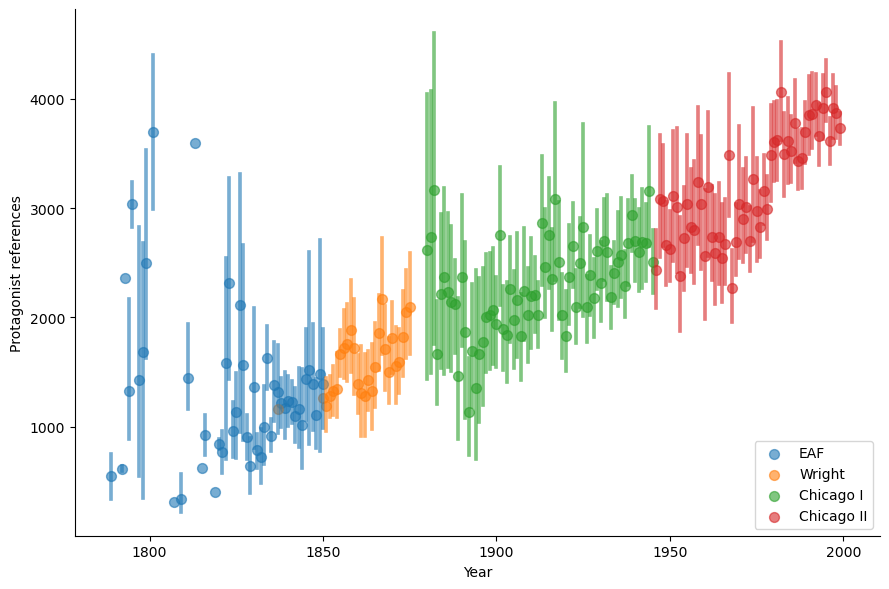

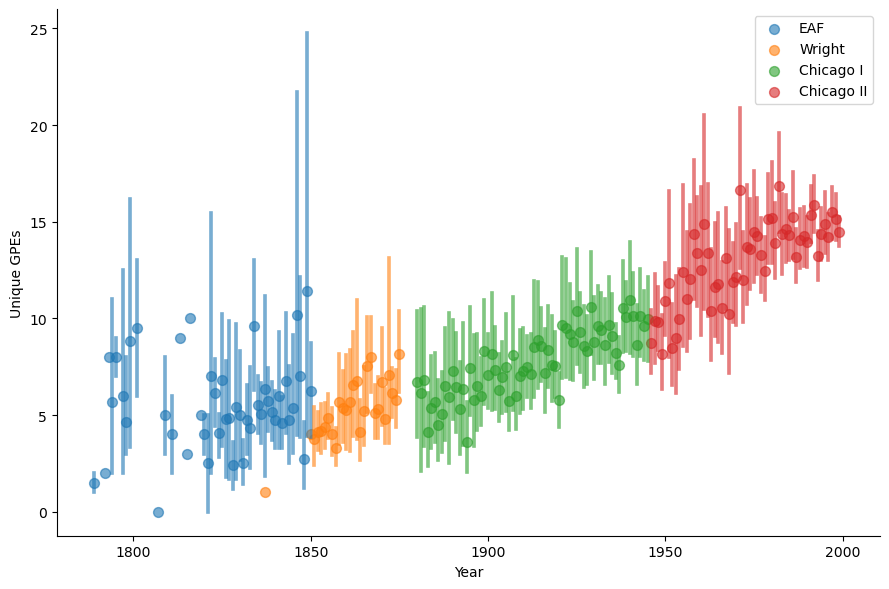

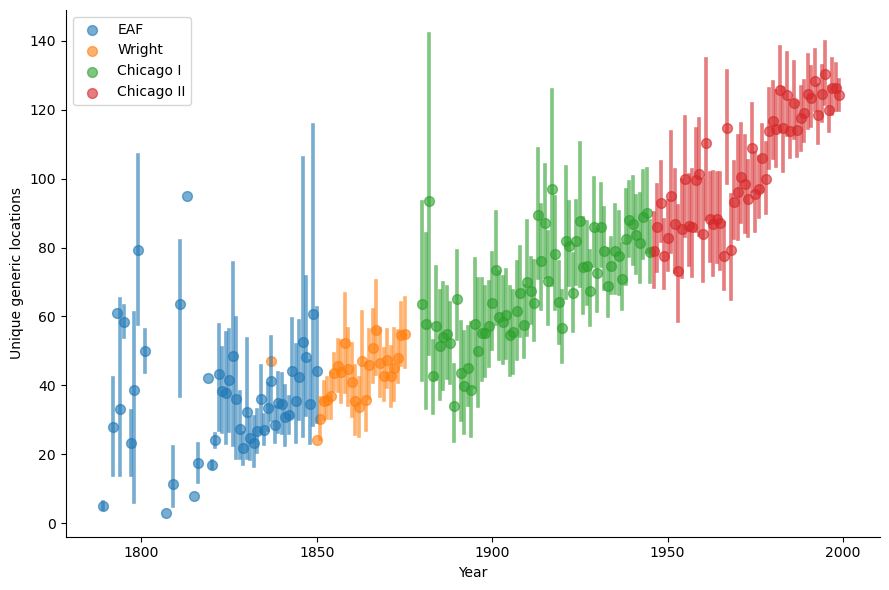

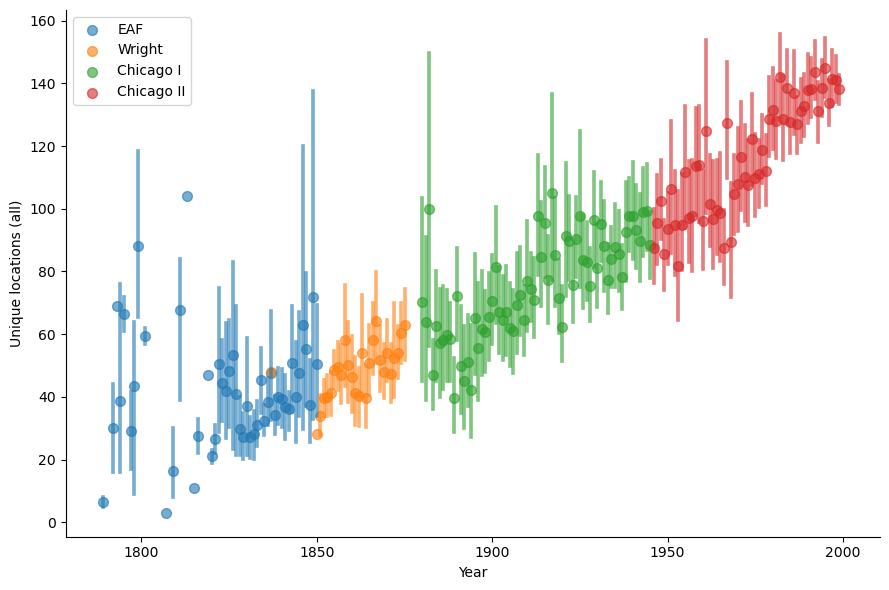

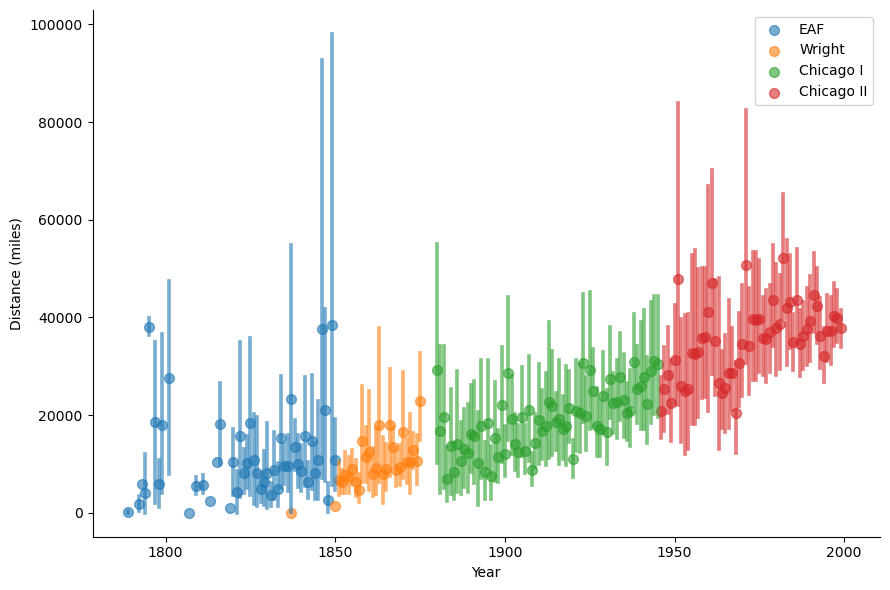

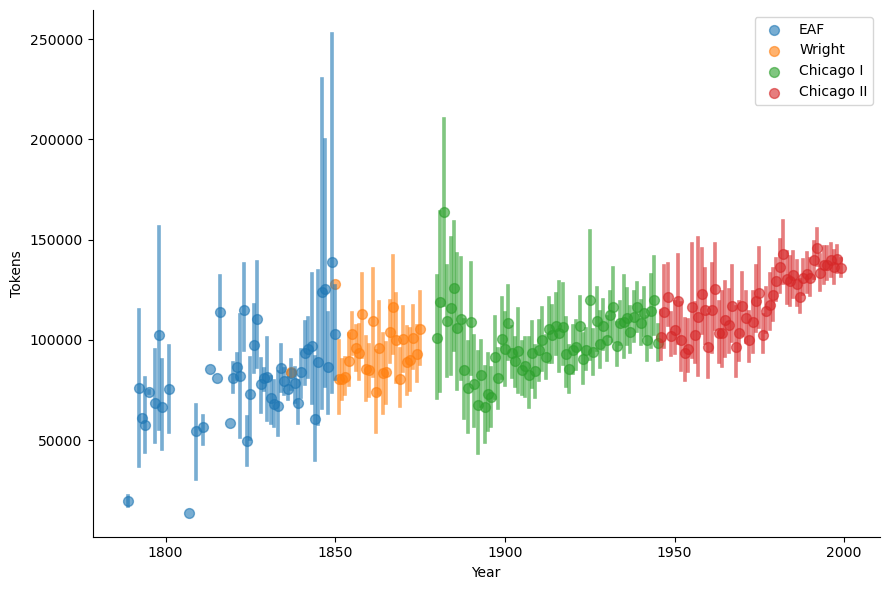

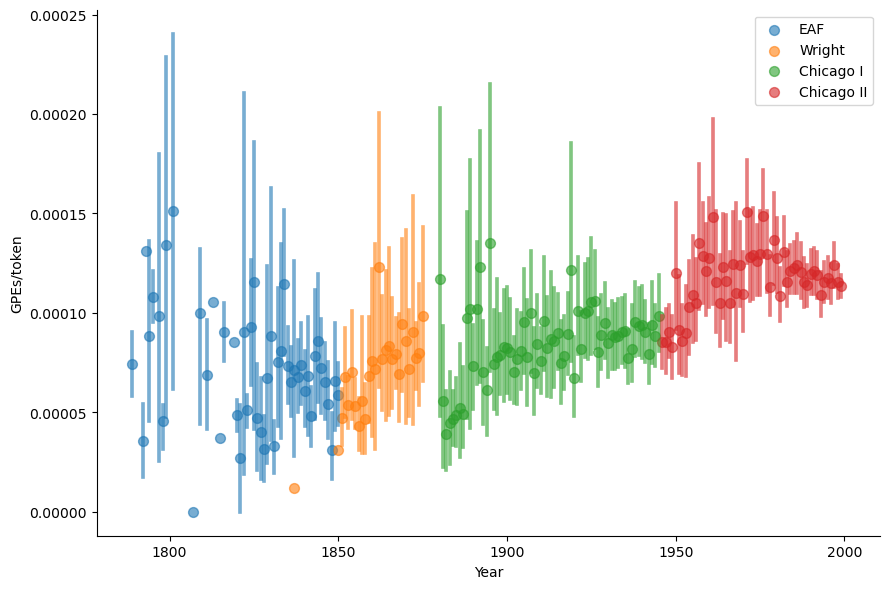

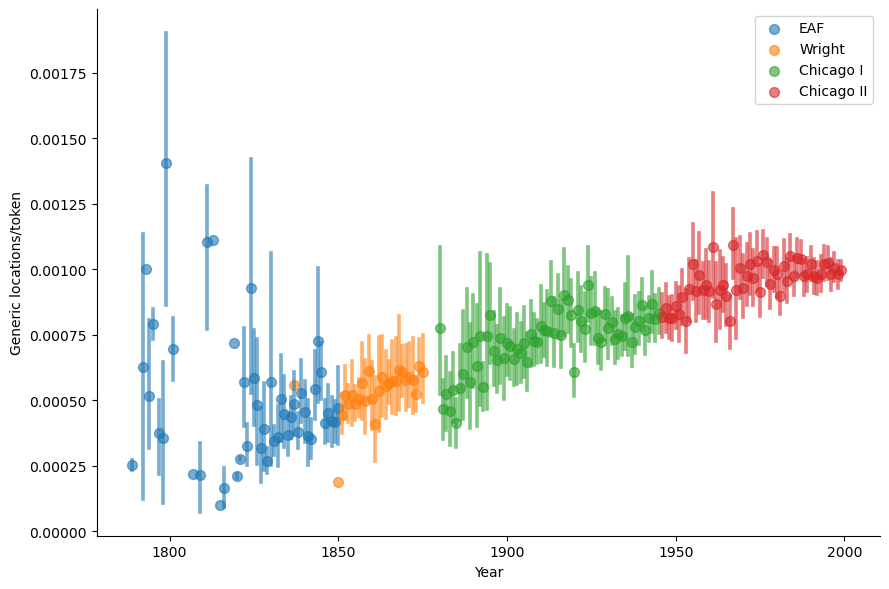

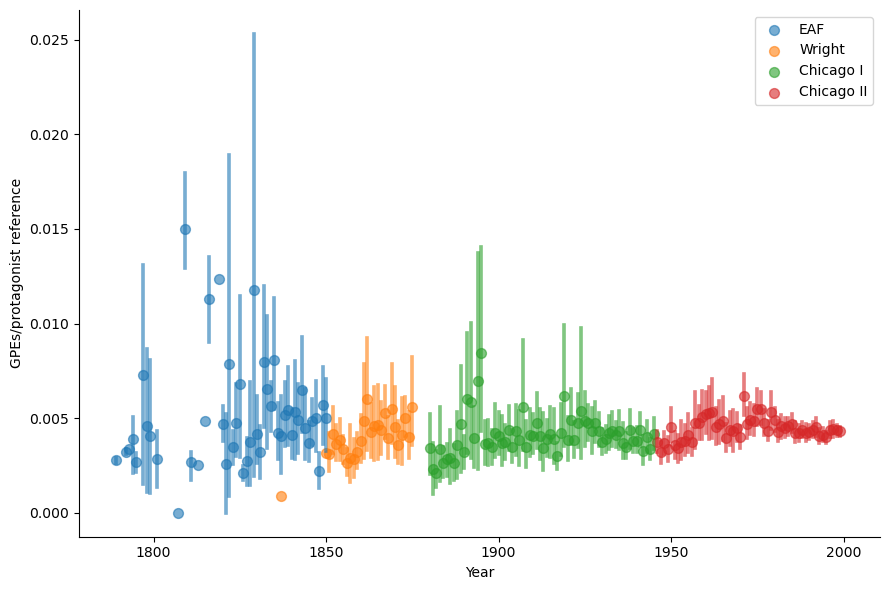

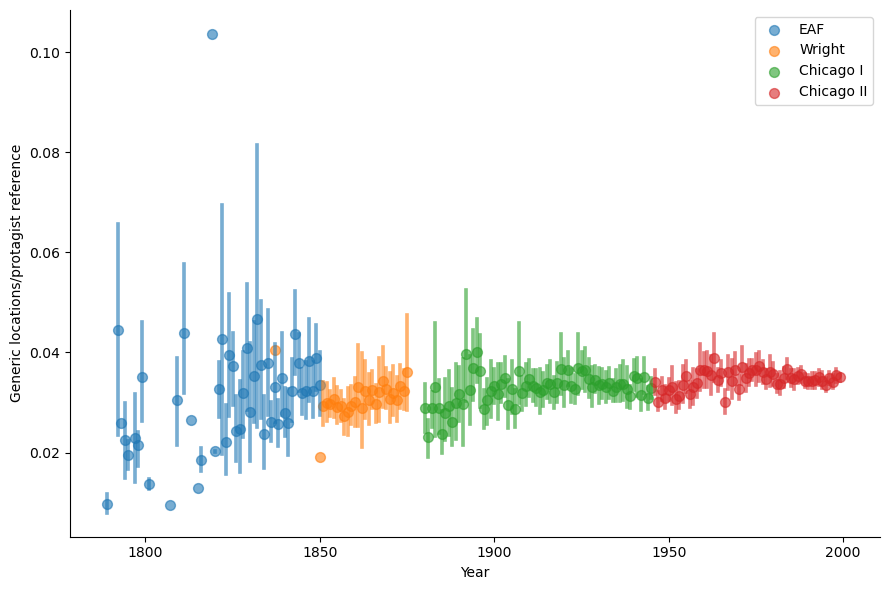

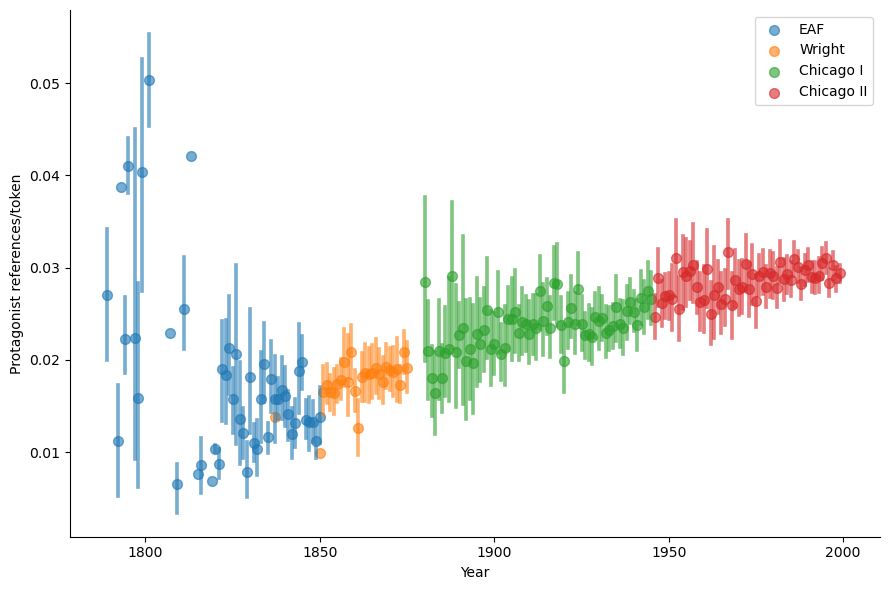

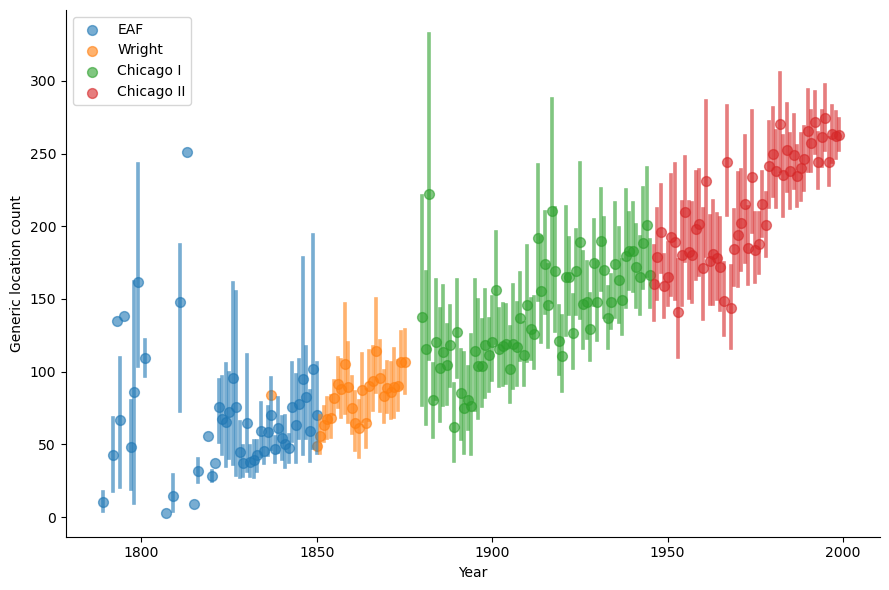

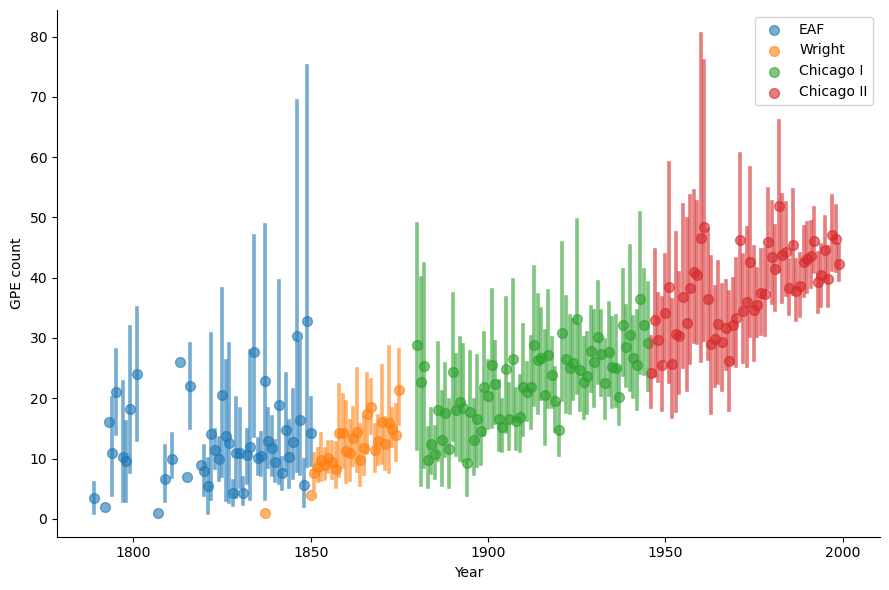

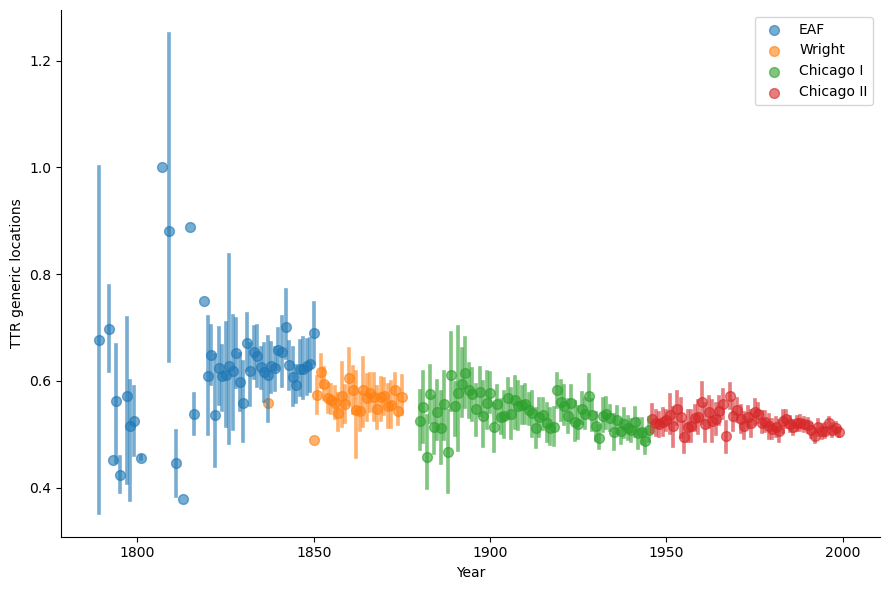

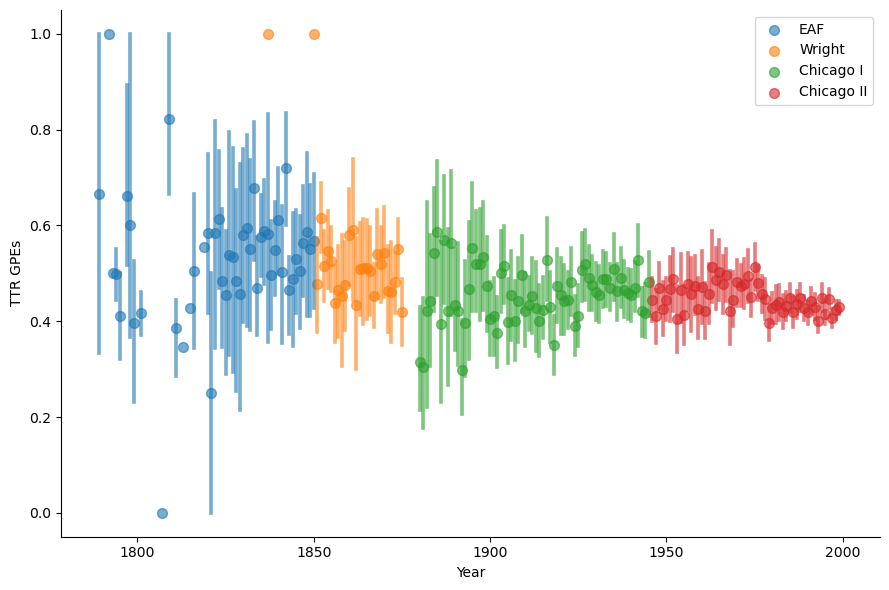

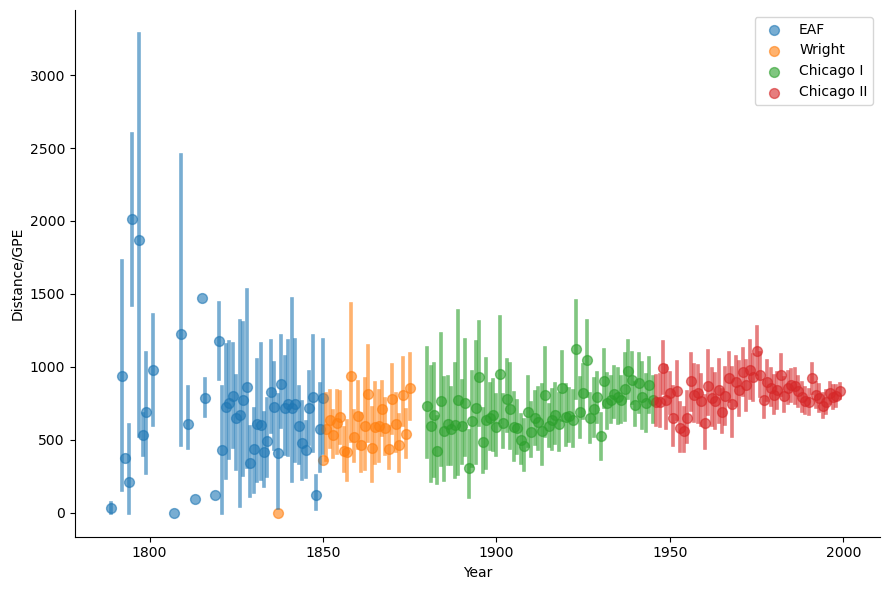

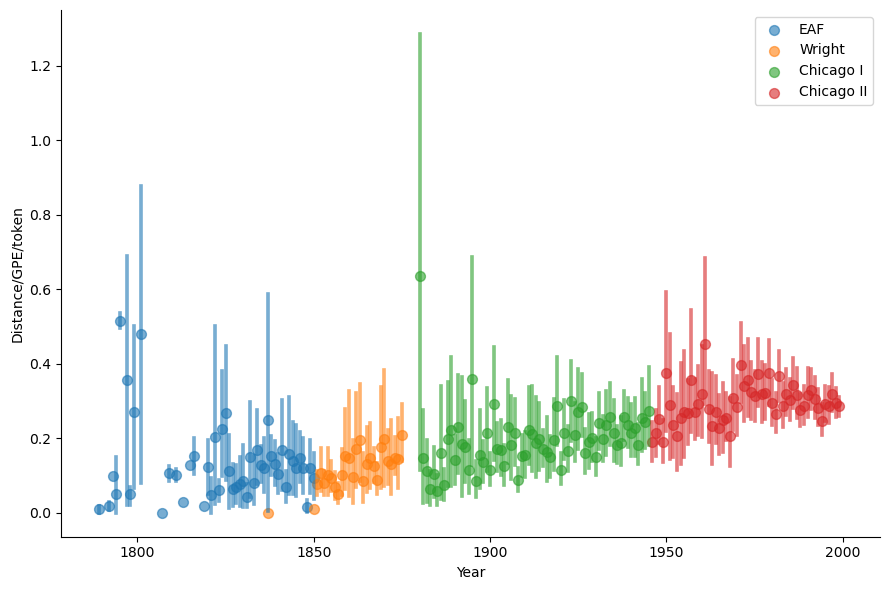

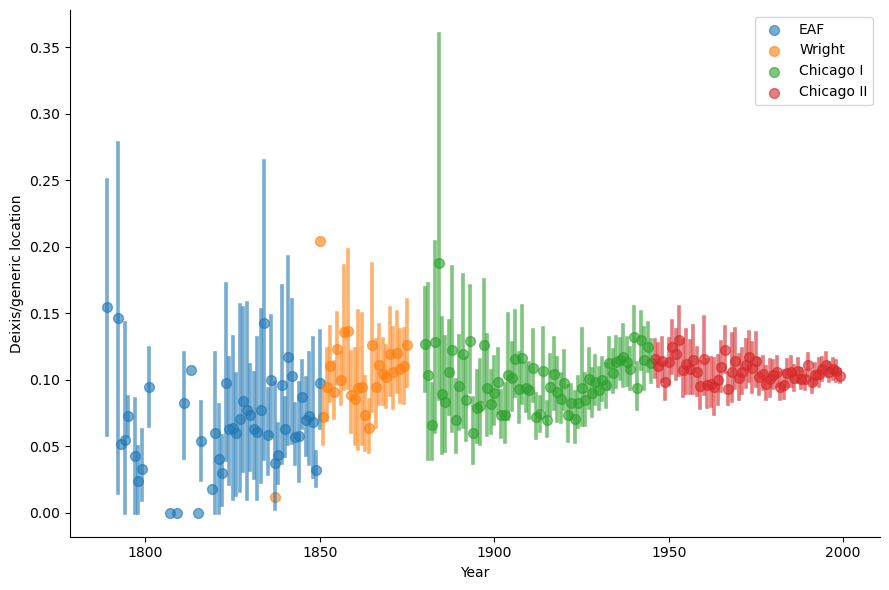

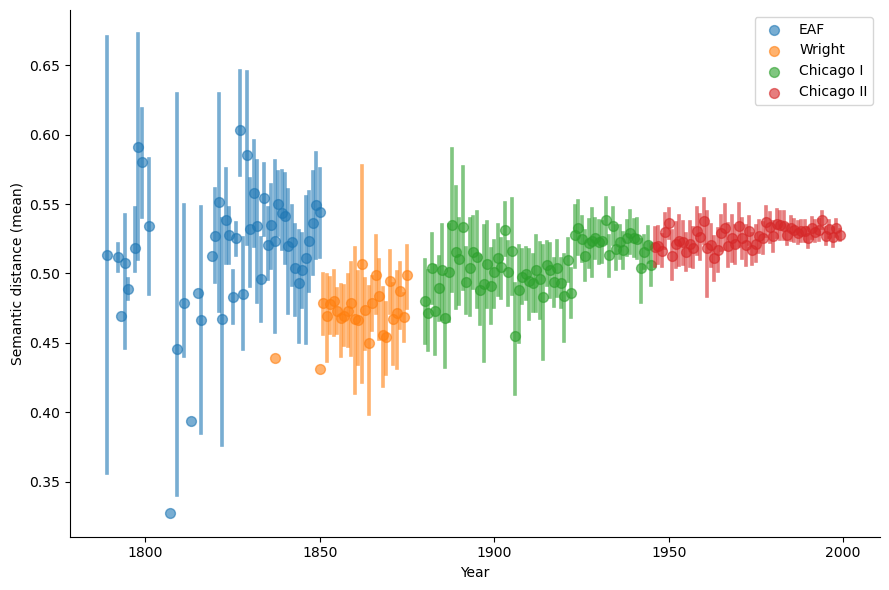

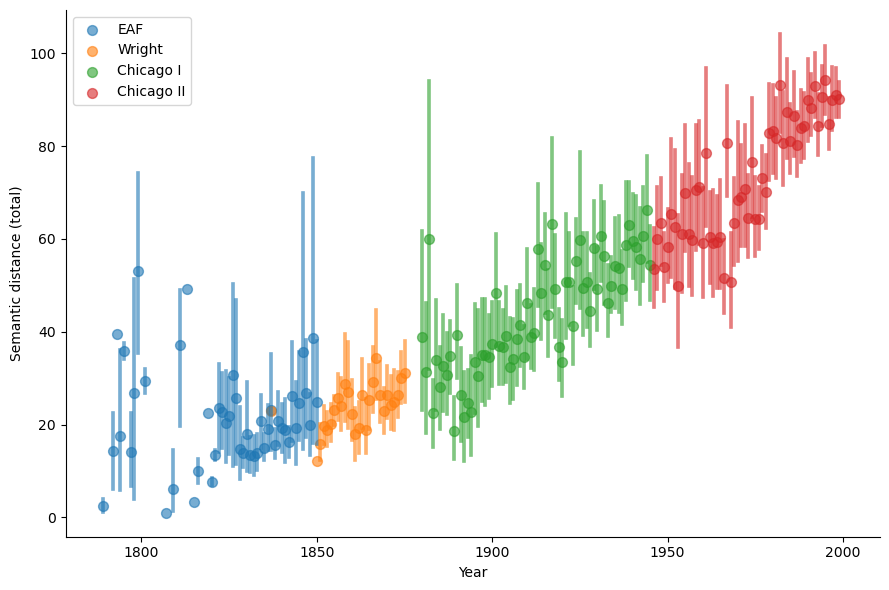

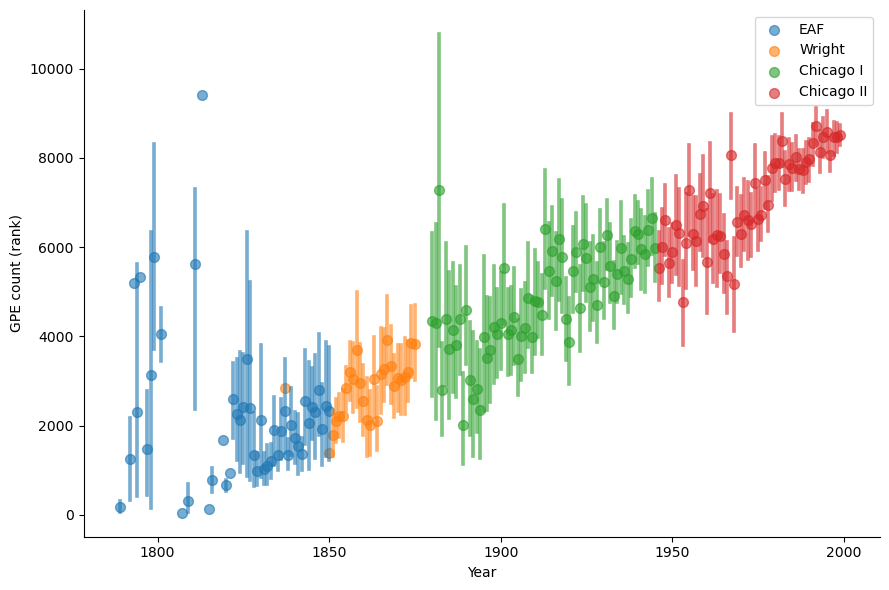

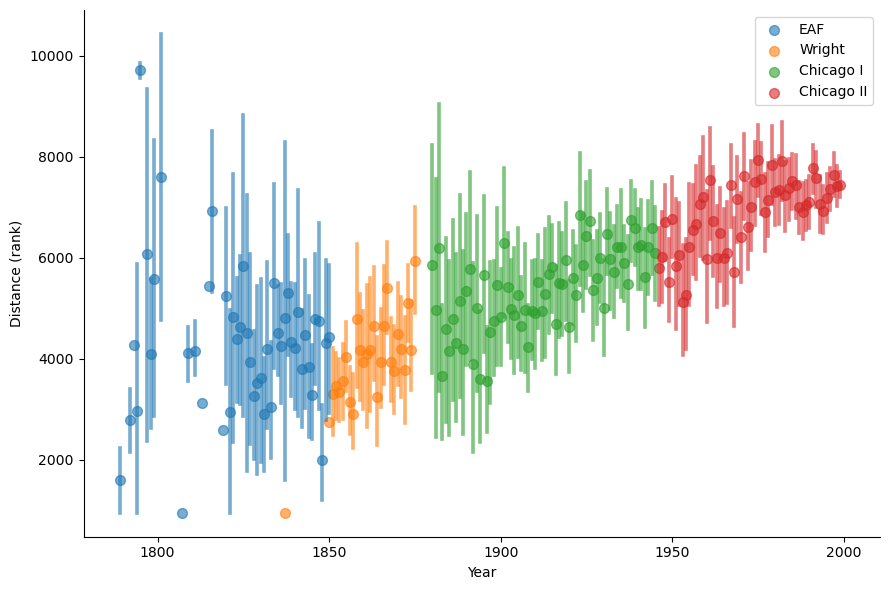

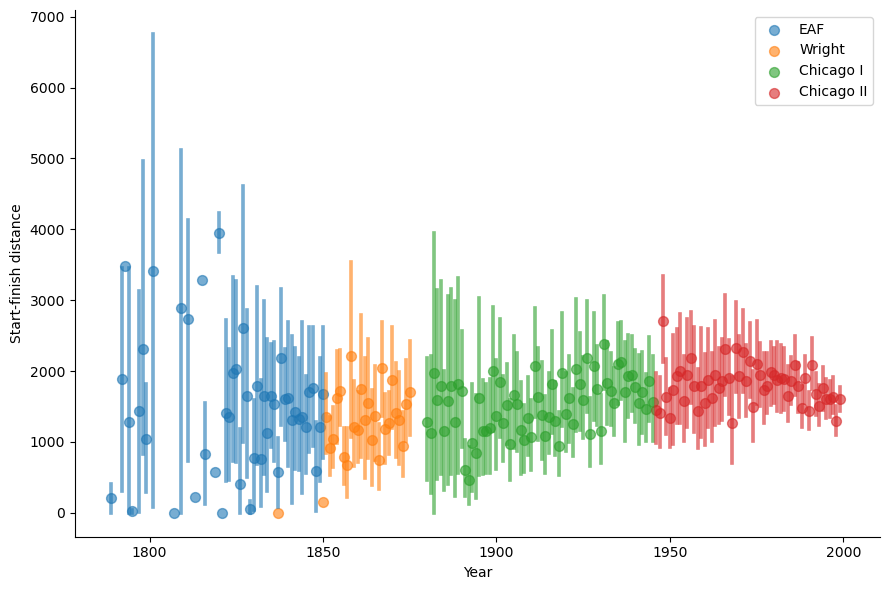

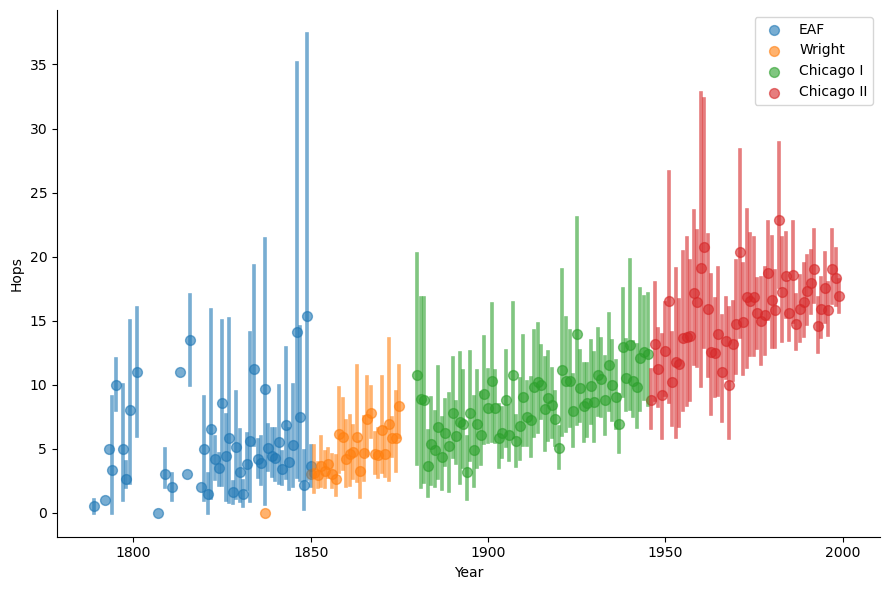

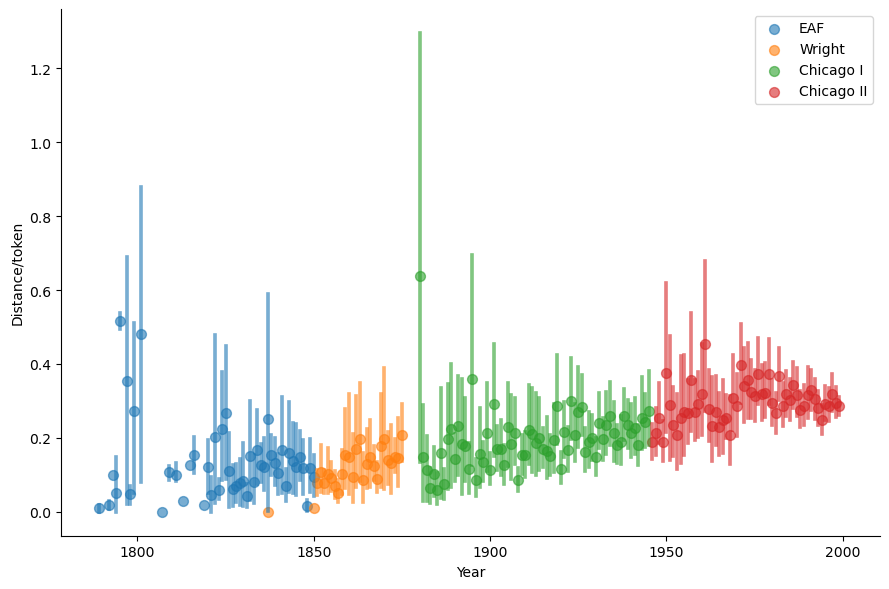

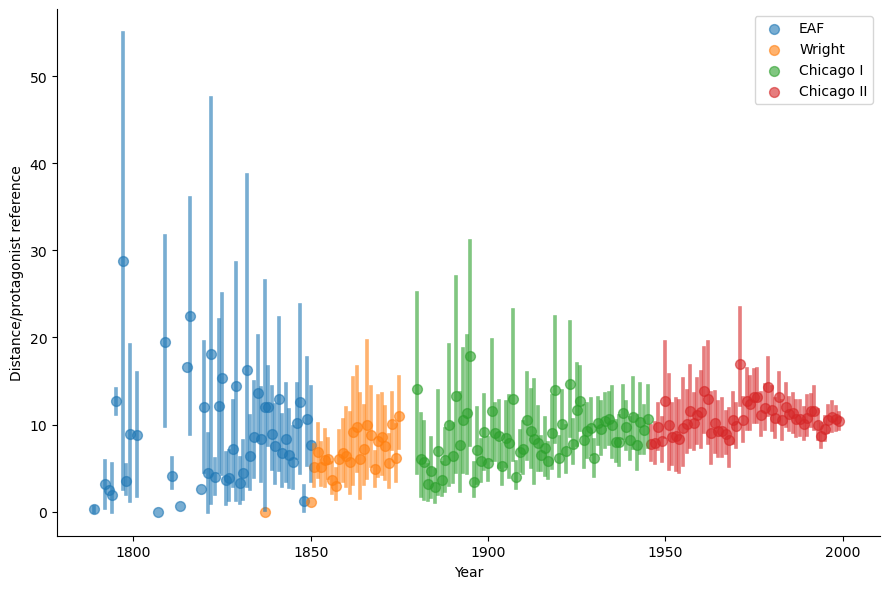

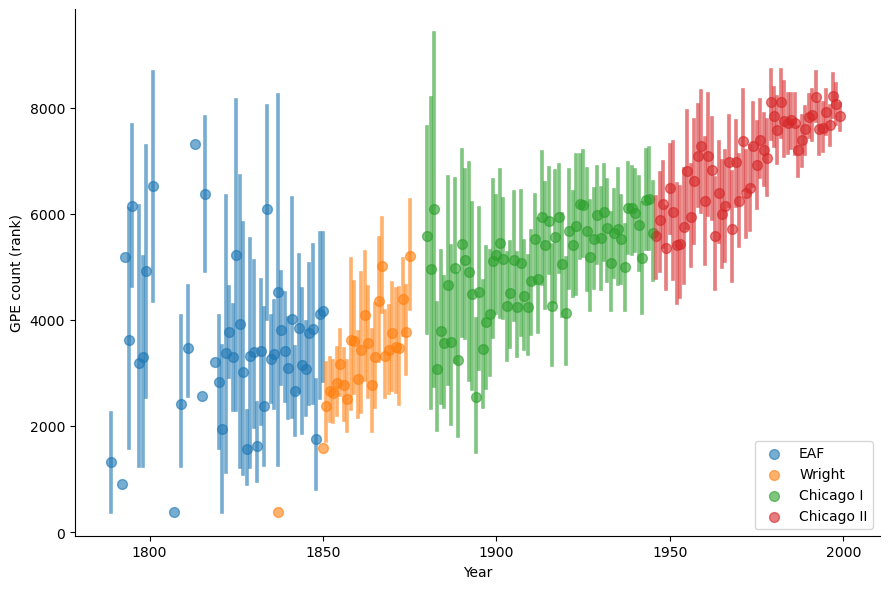

In [24]:
# create plots
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = np.arange(fic_data.pub_date.min(), fic_data.pub_date.max(), 1)
    for col in numeric_cols:
        sns.lmplot(
            x='pub_date', 
            y=col, 
            data=fic_data, 
            #y_partial='Category', # control for fiction/nonfiction
            fit_reg=False,
            x_bins=bins, #fixed total bins by year
            #x_bins=10, # number of bins per collection
            hue='collection',
            hue_order=['EAF', 'Wright', 'Chicago I', 'Chicago II'],
            legend=False,
            height=6,
            aspect=1.5,
            scatter_kws={'alpha':0.6}
        )
        plt.xlabel('Year')
        plt.ylabel(feature_labels[col])
        plt.legend(loc='best')
        plt.tight_layout()
        for ext in vis_formats:
            plt.savefig(
                os.path.join(
                    fig_dir, 
                    'historical_change',
                    f'historical_change_{col}_fiction_by_collection.'+ext
                ), 
                dpi=300
            )
        plt.show()

### Facet by character gender

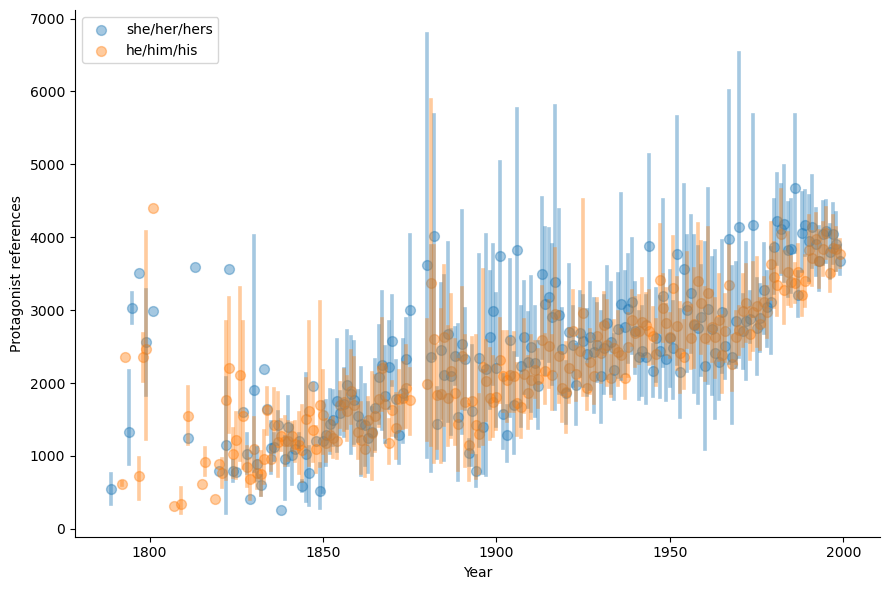

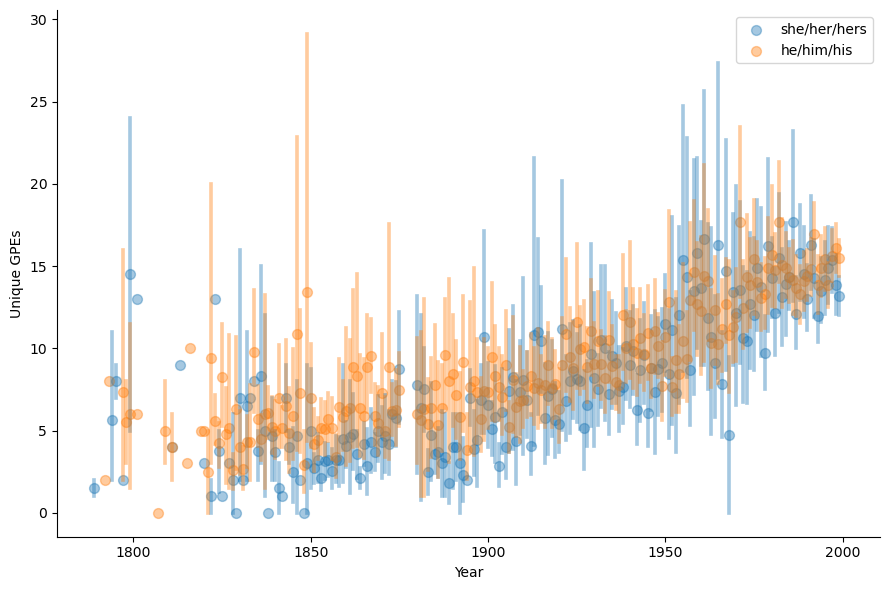

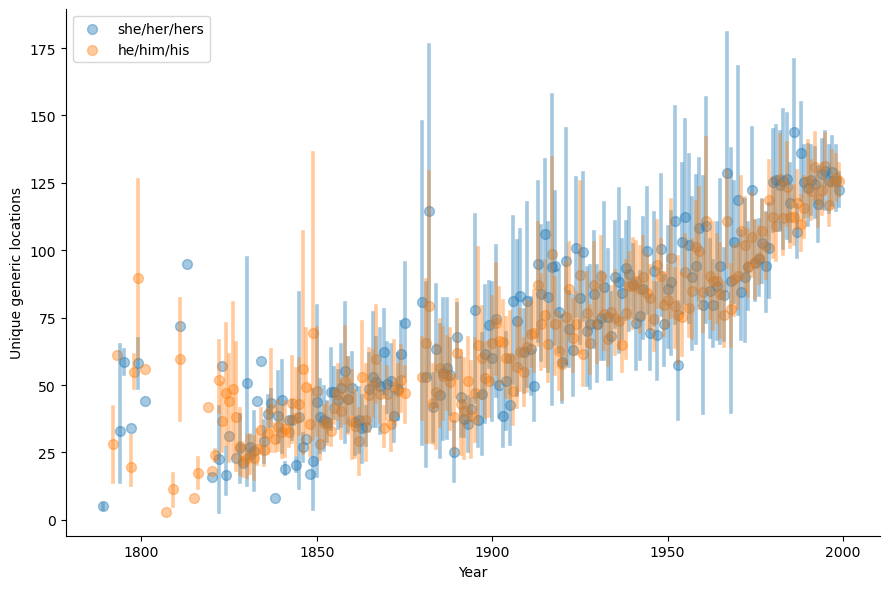

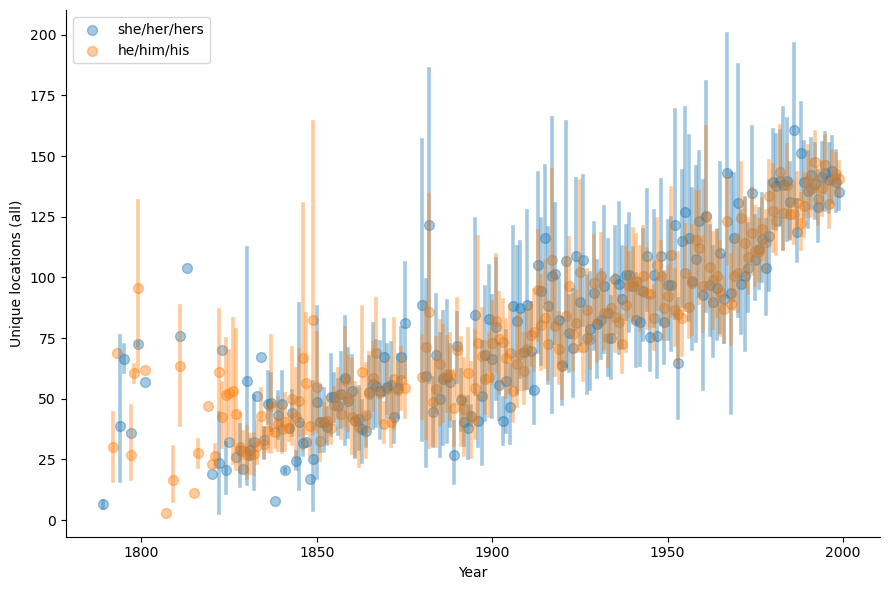

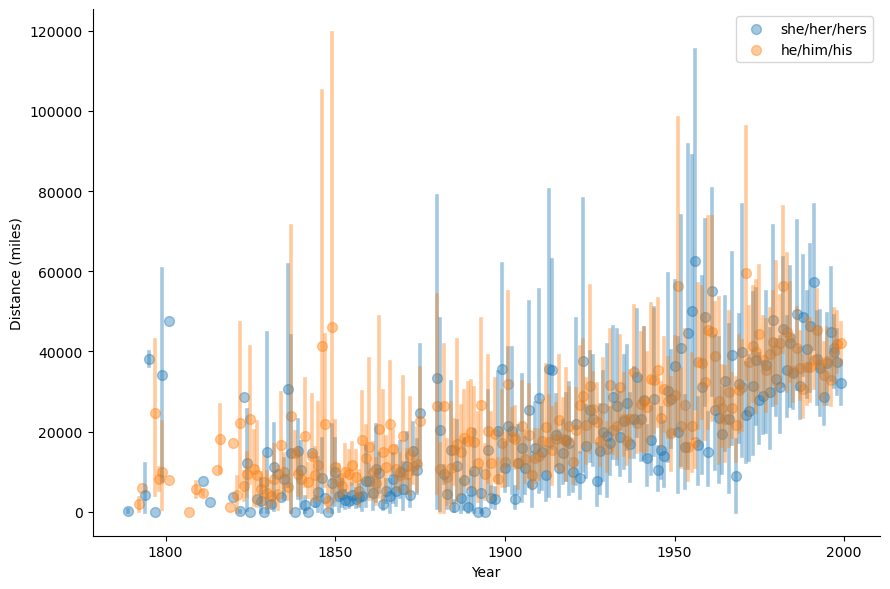

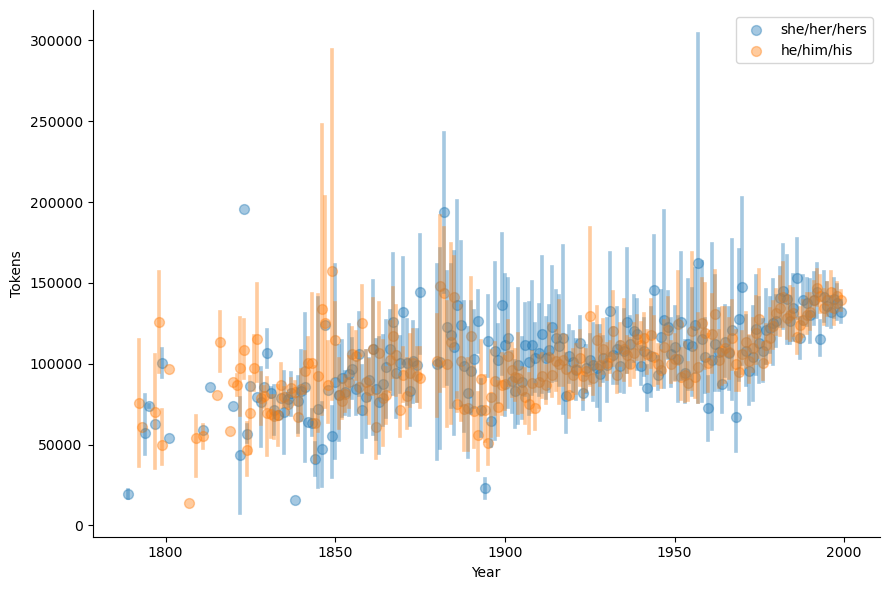

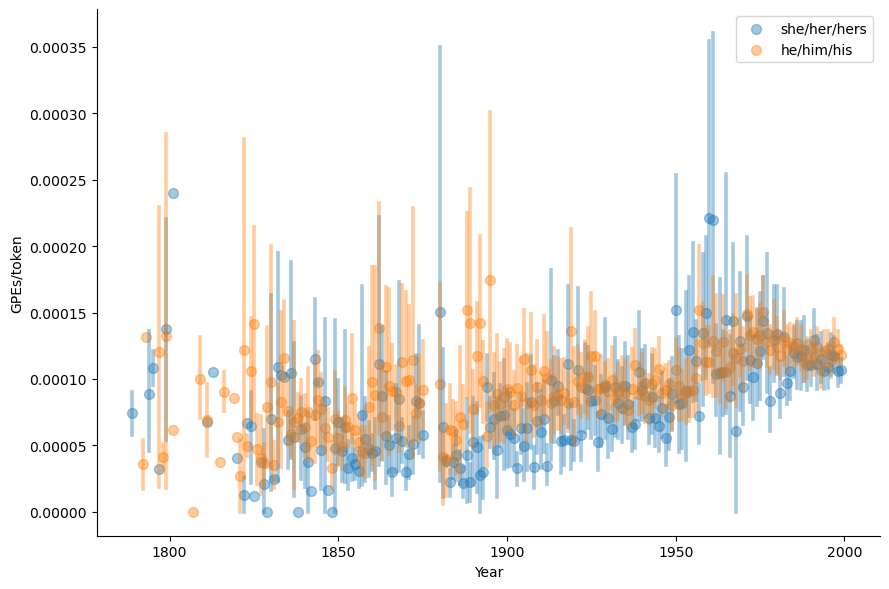

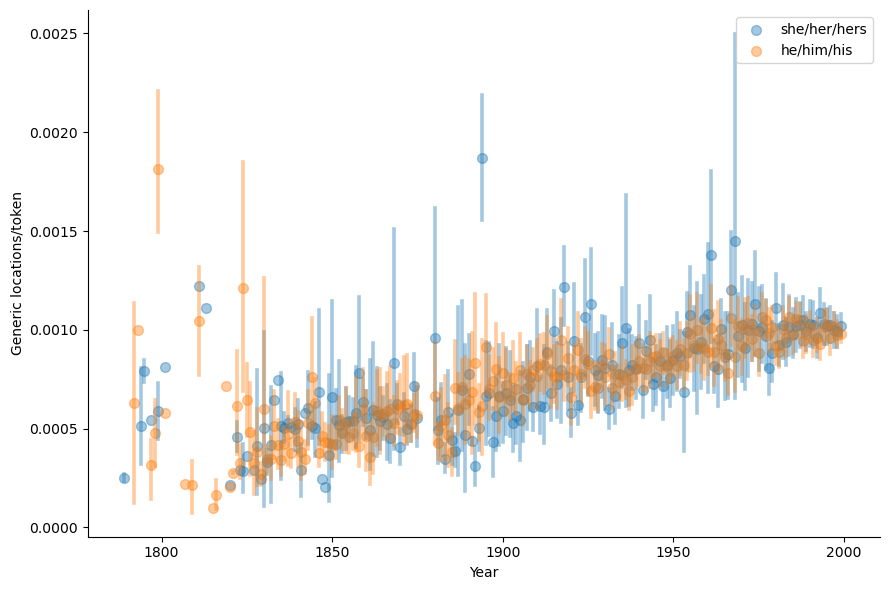

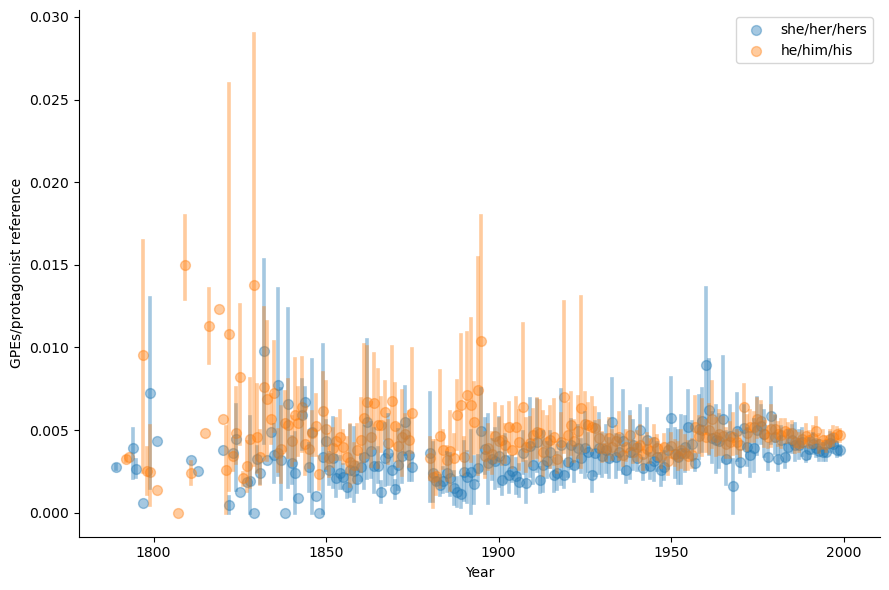

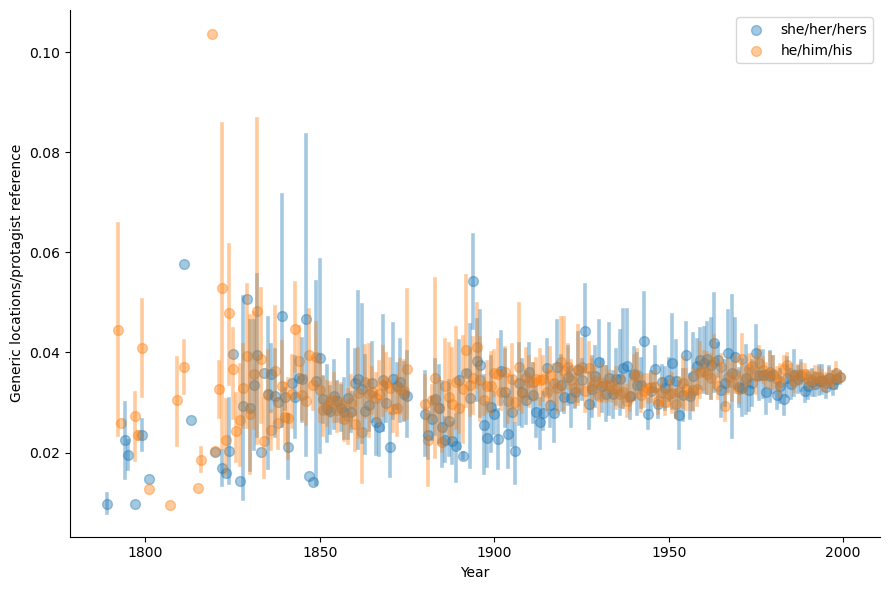

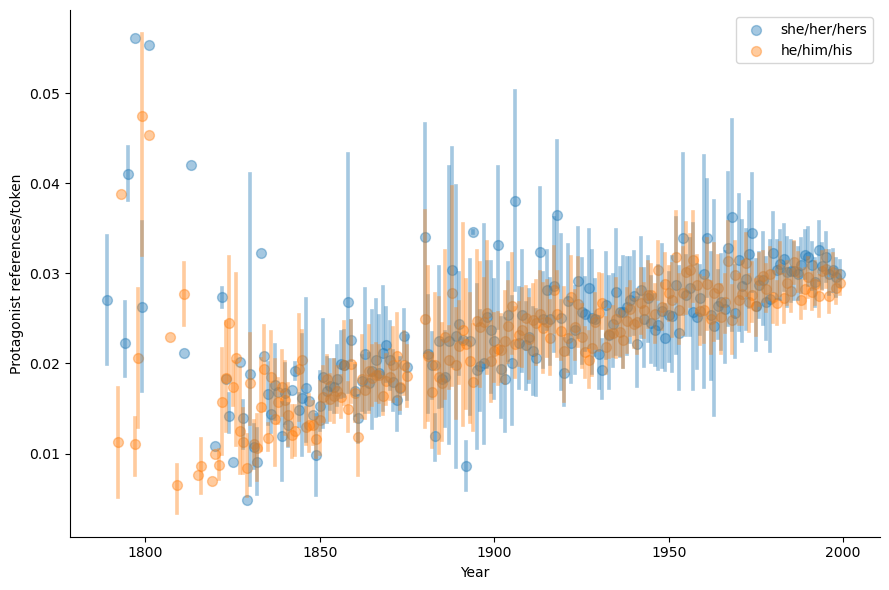

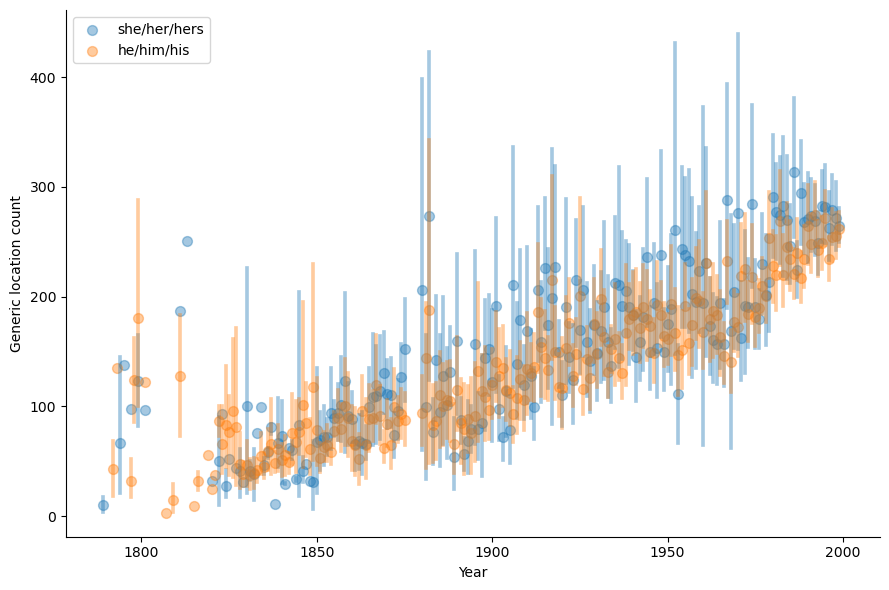

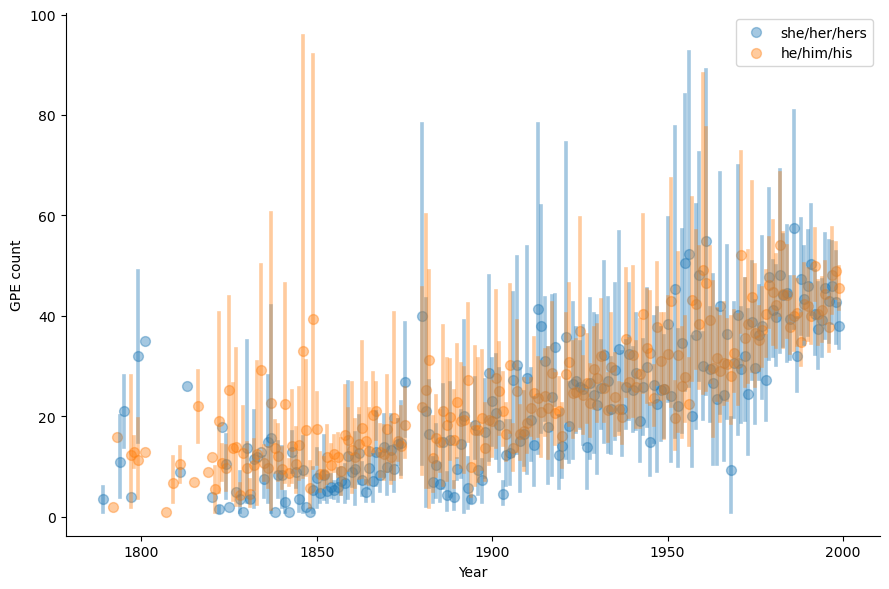

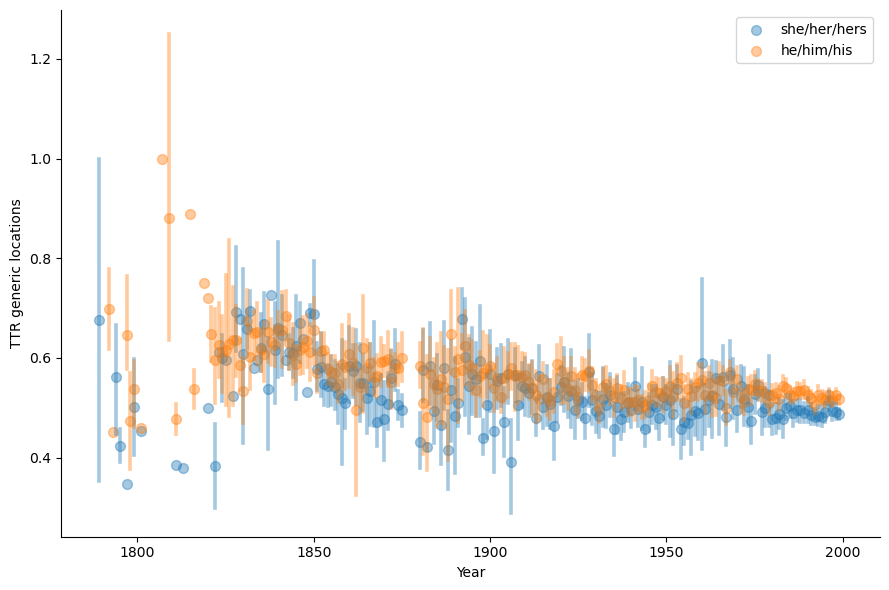

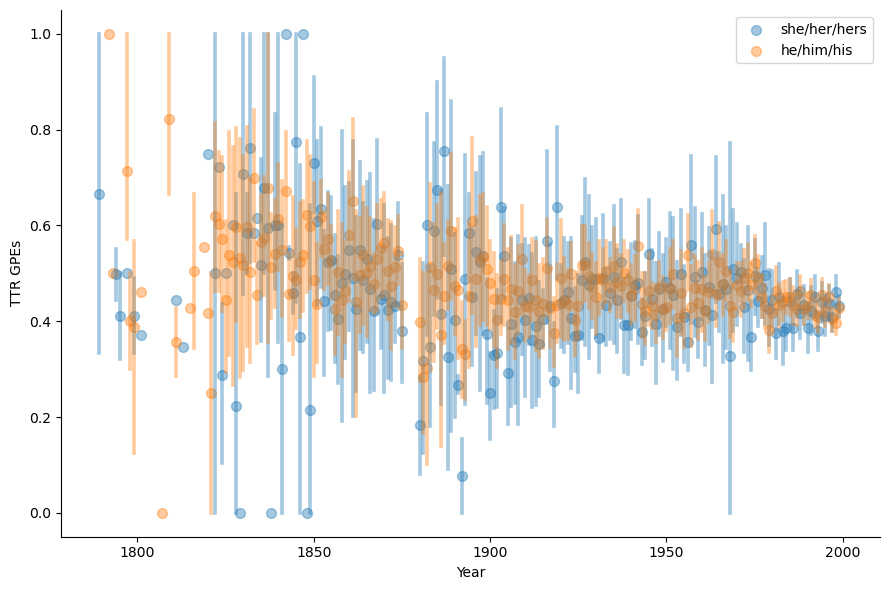

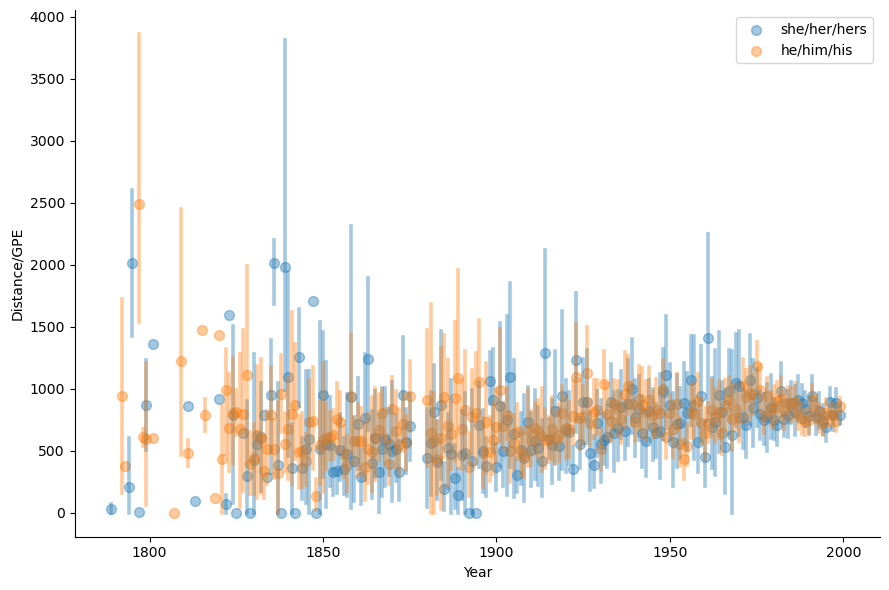

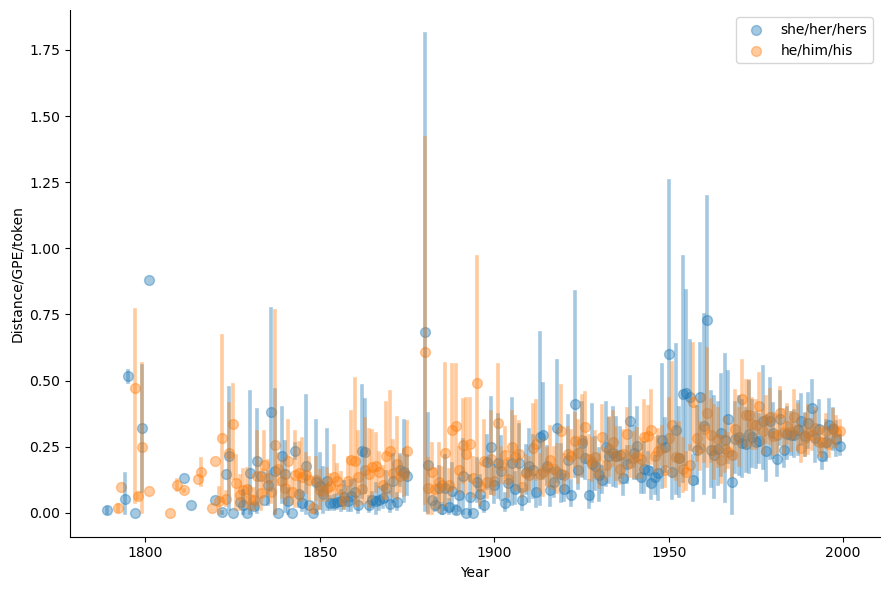

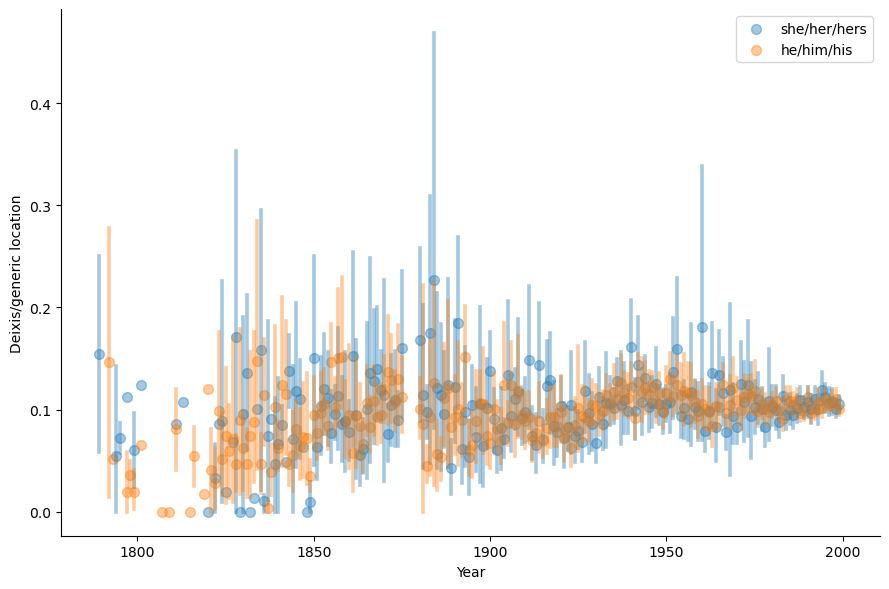

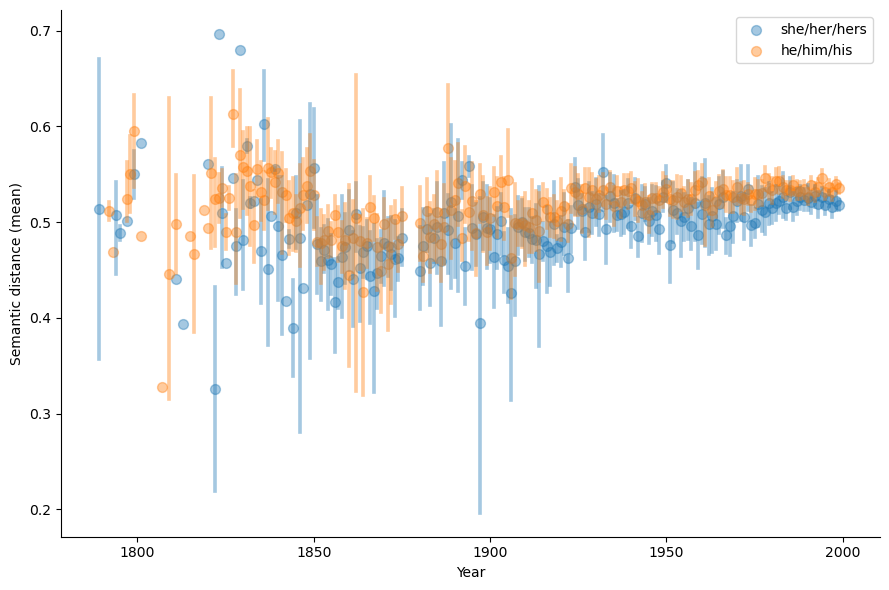

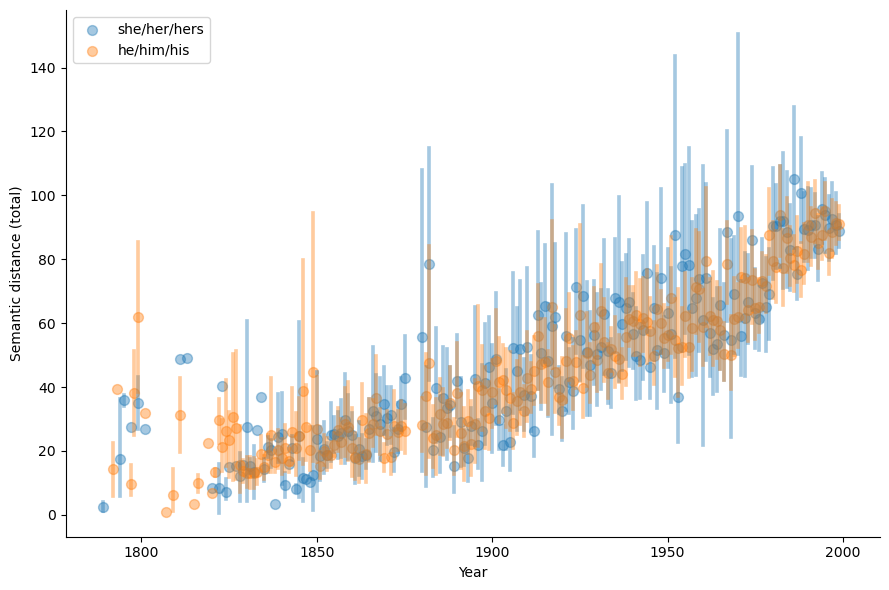

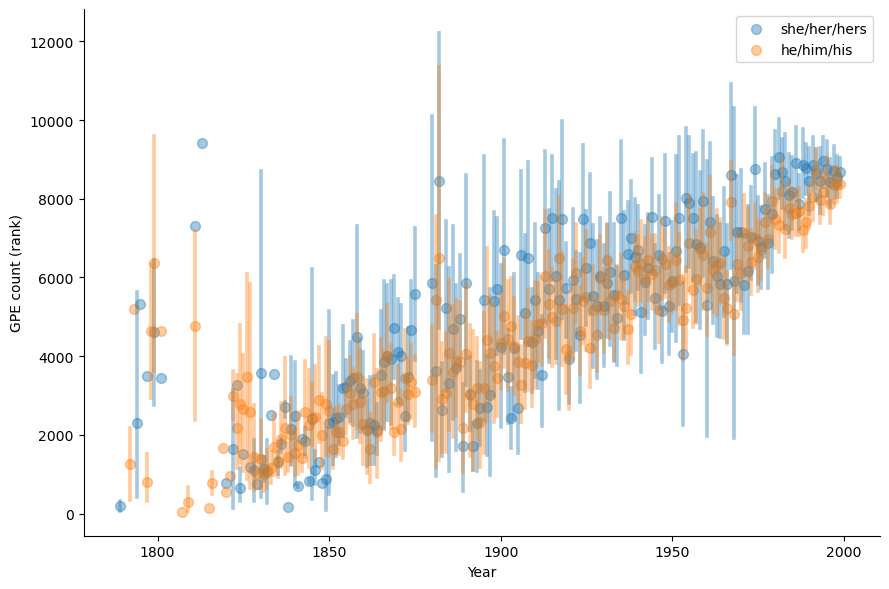

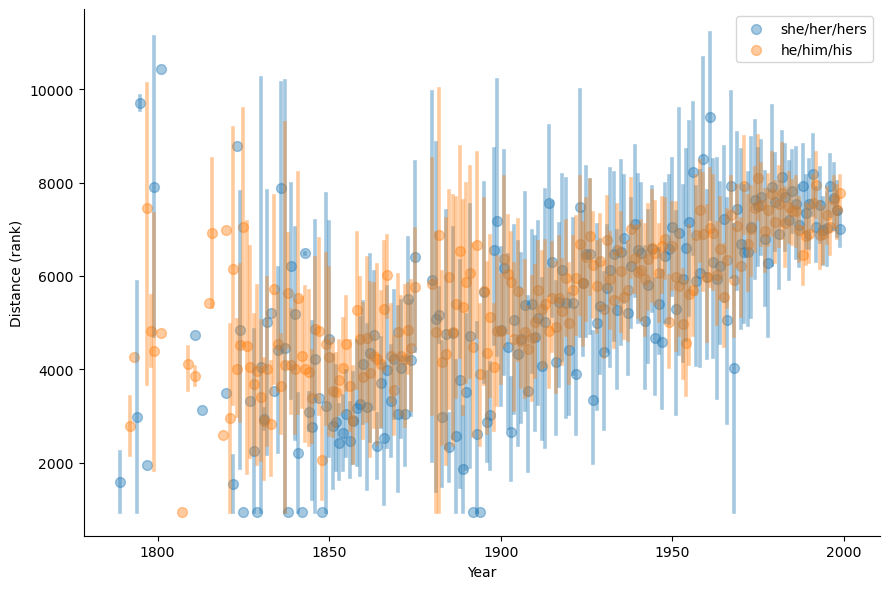

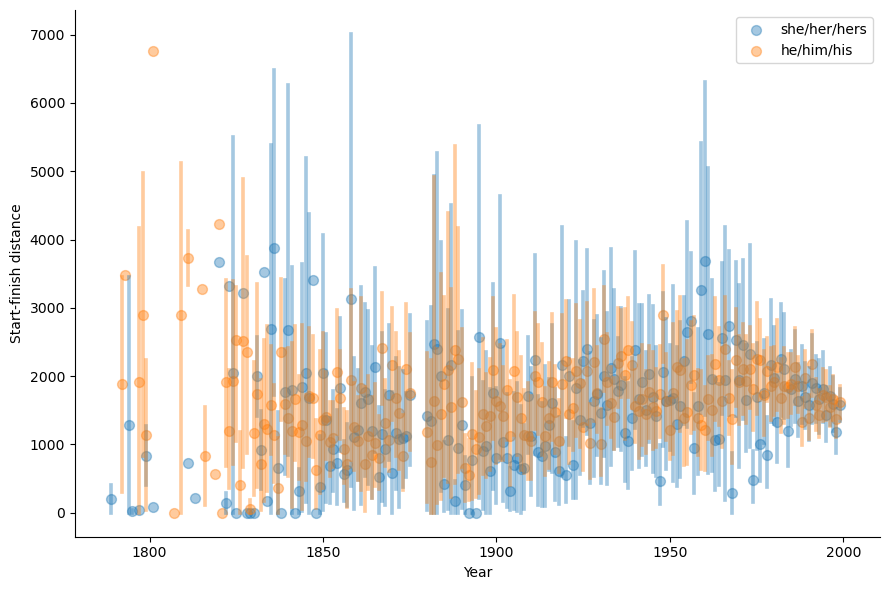

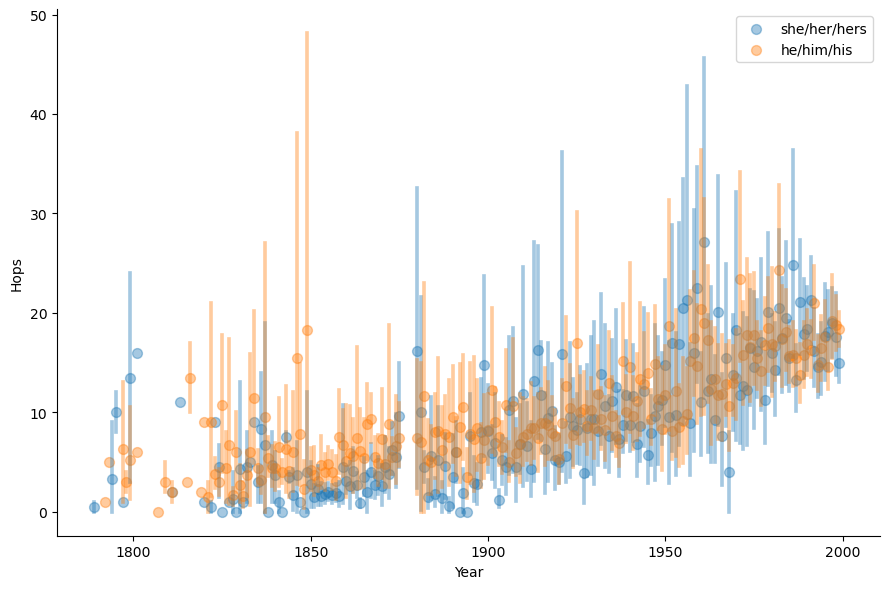

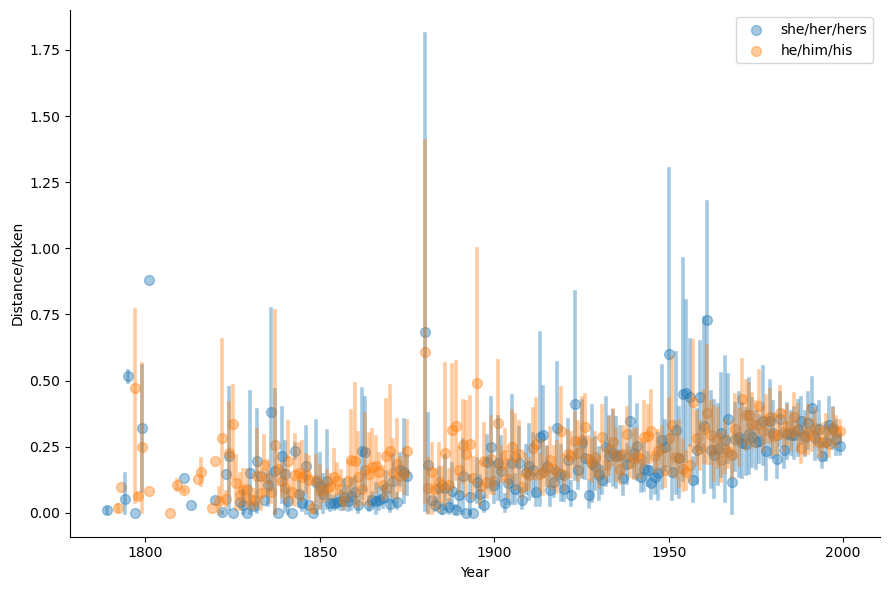

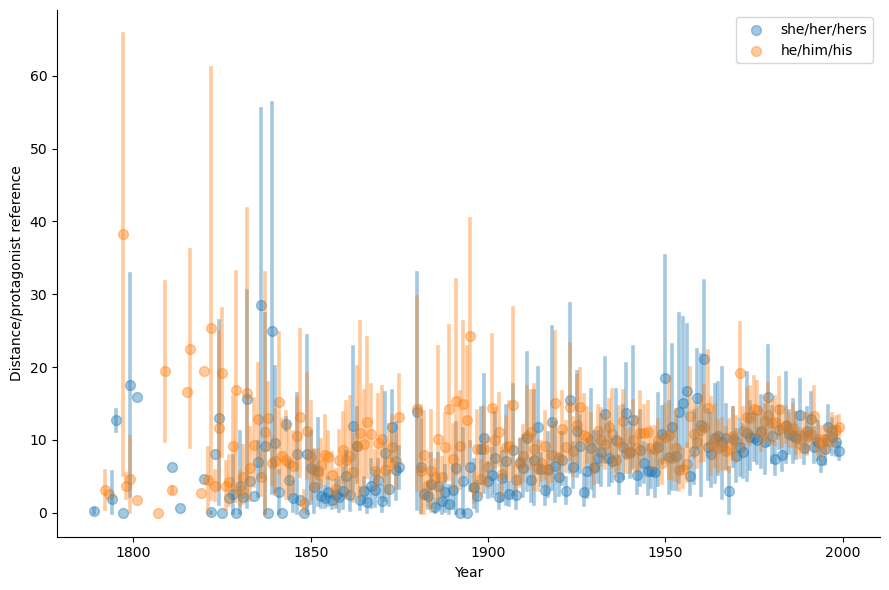

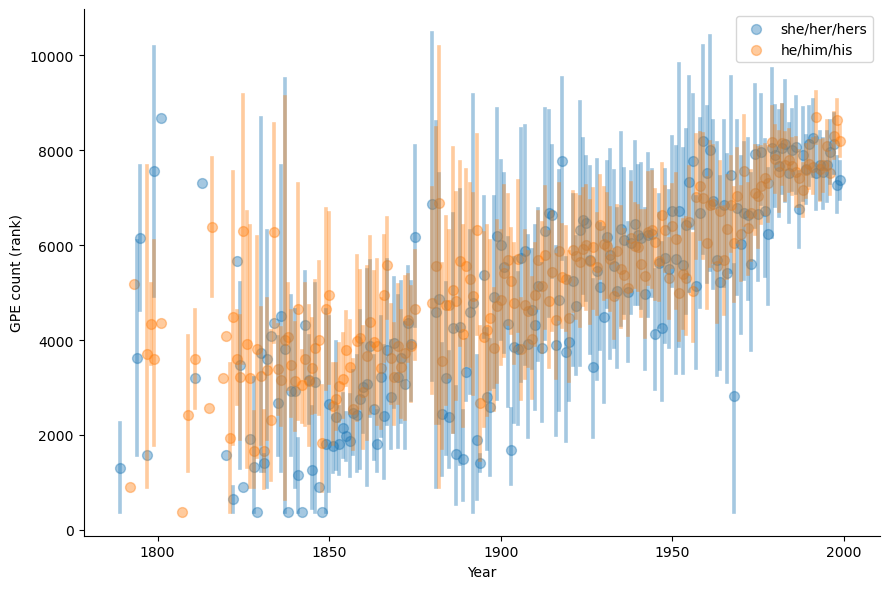

In [25]:
# create plots
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fic_data_gender_limited = fic_data.loc[fic_data.inf_gender.isin(['she/her/hers', 'he/him/his'])]
    bins = np.arange(fic_data.pub_date.min(), fic_data.pub_date.max(), 1)
    for col in numeric_cols:
        sns.lmplot(
            x='pub_date', 
            y=col, 
            data=fic_data_gender_limited, 
            fit_reg=False,
            x_bins=bins, #fixed total bins by year
            hue='inf_gender',
            legend=False,
            height=6,
            aspect=1.5,
            scatter_kws={'alpha':0.4}
        )
        plt.xlabel('Year')
        plt.ylabel(feature_labels[col])
        plt.legend(loc='best')
        plt.tight_layout()
        for ext in vis_formats:
            plt.savefig(
                os.path.join(
                    fig_dir, 
                    'historical_change', 
                    f'historical_change_{col}_fiction_by_char_gender.'+ext
                ), 
                dpi=300
            )
        plt.show()

## Other calculations

Some specific things to investigate for the article.

### Summary stats by corpus and century

In [26]:
# summary stats by subcorpus
for name, group in fic_data_all.groupby('collection'):
    print(name)
    display(group.describe().T)

CONLIT


count           mean            std  \
char_id                              1934.0     108.078077     177.047293   
char_count                           1934.0    4201.894519    2611.314170   
num_gpe_places                       1934.0      13.344881      10.484906   
num_nongpe_places                    1934.0     123.875388      59.475040   
num_all_places                       1934.0     136.805584      66.170604   
dist_miles                           1934.0   38024.078670   52196.102361   
char_rank                            1934.0       1.000000       0.000000   
num_words                            1934.0  320000.000000       0.000000   
Tokens                               1934.0  121620.681489   59429.422467   
num_gpe_places_norm                  1934.0       0.000117       0.000091   
num_nongpe_places_norm               1934.0       0.001116       0.000502   
num_gpe_places_norm_byCharacter      1934.0       0.003816       0.003094   
num_nongpe_places_norm_byCharacter   1934.0       0.033306       0.012665   
char_count_norm                      1934.0       0.036964       0.017737   
nongpe_places_total                  1934.0     275.668046     159.482844   
gpe_places_total                     1934.0      38.888831      38.974311   
ttr_nongpe                           1934.0       0.483171       0.098638   
ttr_gpe                              1934.0       0.434065       0.205825   
avg_Distance_GPE                     1934.0     868.661990     716.683667   
non_gpe_ratio                        1897.0      14.331291      14.935405   
avg_Distance_GPE_Tokens              1934.0       0.327338       0.440501   
deixis_count_perplace                1934.0       0.109243       0.063115   
semantic_dist_mean                   1934.0       0.521991       0.049880   
semantic_dist_total                  1934.0      91.591084      52.064313   
dist_miles_allChars                  1934.0   91745.375475  114875.905889   
dist_miles_allChars_norm_Tokens      1934.0       0.756511       0.864245   
num_gpe_places_allChars_norm_Tokens  1934.0       0.000344       0.000222   
non_gpe_total_rank                   1934.0    8720.833247    3256.556604   
dist_miles_rank                      1934.0    7299.891934    3671.639953   
pub_date                             1934.0    2013.463806       2.840743   
Start_Finish_Miles                   1934.0    1854.249567    2415.824941   
Start_Finish_Z                       1861.0      -1.596047      47.985135   
first_last_SemanticDist              1709.0       0.491751       0.263776   
hops                                 1934.0      15.555326      17.845019   
dist_miles_norm                      1934.0       0.327338       0.440501   
dist_miles_norm_byCharacter          1934.0      10.135320      13.026044   
gpe_total_rank                       1934.0    7327.588418    3584.827149   

                                               min            25%  \
char_id                                   0.000000       0.000000   
char_count                              326.000000    2506.000000   
num_gpe_places                            0.000000       6.000000   
num_nongpe_places                        10.000000      84.000000   
num_all_places                           11.000000      91.250000   
dist_miles                                0.000000    6386.051101   
char_rank                                 1.000000       1.000000   
num_words                            320000.000000  320000.000000   
Tokens                                15548.000000   89119.250000   
num_gpe_places_norm                       0.000000       0.000054   
num_nongpe_places_norm                    0.000031       0.000768   
num_gpe_places_norm_byCharacter           0.000000       0.001647   
num_nongpe_places_norm_byCharacter        0.006065       0.024372   
char_count_norm                           0.002710       0.022782   
nongpe_places_total                      14.000000     165.000000   
gpe_pla

Chicago I


count           mean           std  \
char_id                              2608.0     137.823620    161.766871   
char_count                           2608.0    2379.816334   1614.889900   
num_gpe_places                       2608.0       8.378067      8.086396   
num_nongpe_places                    2608.0      72.930598     47.966834   
num_all_places                       2608.0      81.085506     53.224229   
dist_miles                           2608.0   21023.007347  33545.866285   
char_rank                            2608.0       1.000000      0.000000   
num_words                               0.0            NaN           NaN   
Tokens                               2608.0  101372.885353  54127.288289   
num_gpe_places_norm                  2608.0       0.000087      0.000080   
num_nongpe_places_norm               2608.0       0.000767      0.000433   
num_gpe_places_norm_byCharacter      2608.0       0.004134      0.004637   
num_nongpe_places_norm_byCharacter   2608.0       0.033305      0.013598   
char_count_norm                      2608.0       0.024151      0.011556   
nongpe_places_total                  2608.0     149.995399    118.205989   
gpe_places_total                     2608.0      24.370015     30.743803   
ttr_nongpe                           2608.0       0.533310      0.114192   
ttr_gpe                              2608.0       0.458647      0.250618   
avg_Distance_GPE                     2608.0     731.211422    735.826381   
non_gpe_ratio                        2472.0      13.652216     13.597897   
avg_Distance_GPE_Tokens              2608.0       0.202780      0.303265   
deixis_count_perplace                2608.0       0.100034      0.081078   
semantic_dist_mean                   2608.0       0.510622      0.072524   
semantic_dist_total                  2608.0      47.976311     37.445915   
dist_miles_allChars                     0.0            NaN           NaN   
dist_miles_allChars_norm_Tokens         0.0            NaN           NaN   
num_gpe_places_allChars_norm_Tokens     0.0            NaN           NaN   
non_gpe_total_rank                   2608.0    5176.600460   3406.949940   
dist_miles_rank                      2608.0    5604.318060   3573.019477   
pub_date                             2608.0    1921.407209     16.567741   
Start_Finish_Miles                   2608.0    1604.249165   2243.110221   
Start_Finish_Z                       2387.0      -7.333378    254.289278   
first_last_SemanticDist              2056.0       0.461349      0.268773   
hops                                 2608.0       9.215874     13.754512   
dist_miles_norm                      2608.0       0.202755      0.303237   
dist_miles_norm_byCharacter          2608.0       8.960691     13.262040   
gpe_total_rank                       2608.0    5315.823811   3647.674603   

                                              min           25%           50%  \
char_id                                  0.000000     39.000000    110.000000   
char_count                              24.000000   1306.500000   2070.000000   
num_gpe_places                           0.000000      3.000000      6.000000   
num_nongpe_places                        0.000000     41.000000     64.000000   
num_all_places                           0.000000     45.000000     71.500000   
dist_miles                               0.000000    660.590682   9661.474893   
char_rank                                1.000000      1.000000      1.000000   
num_words                                     NaN           NaN           NaN   
Tokens                                 319.000000  72022.000000  94556.500000   
num_gpe_places_norm                      0.000000      0.000035      0.000068   
num_nongpe_places_norm                   0.000000      0.000467      0.000691   
num_gpe_places_norm_byCharacter          0.000000      0.001649      0.003026   
num_nongpe_places_norm_byCharacter       0.000000      0.024666      0.030993   
char_count_norm

Chicago II


count           mean           std  \
char_id                              6481.0     152.765160    241.491134   
char_count                           6481.0    3471.956642   2096.353397   
num_gpe_places                       6481.0      13.794939     11.096605   
num_nongpe_places                    6481.0     112.956951     62.016113   
num_all_places                       6481.0     126.336059     69.426267   
dist_miles                           6481.0   37023.219917  54398.102066   
char_rank                            6481.0       1.000000      0.000000   
num_words                               0.0            NaN           NaN   
Tokens                               6481.0  127054.627527  67357.363893   
num_gpe_places_norm                  6481.0       0.000117      0.000089   
num_nongpe_places_norm               6481.0       0.000976      0.000469   
num_gpe_places_norm_byCharacter      6481.0       0.004394      0.003246   
num_nongpe_places_norm_byCharacter   6481.0       0.034702      0.011122   
char_count_norm                      6481.0       0.028984      0.012534   
nongpe_places_total                  6481.0     234.133621    153.689185   
gpe_places_total                     6481.0      40.316309     43.598536   
ttr_nongpe                           6481.0       0.517412      0.095550   
ttr_gpe                              6481.0       0.439124      0.198701   
avg_Distance_GPE                     6481.0     820.957756    677.333927   
non_gpe_ratio                        6397.0      11.826090     10.837067   
avg_Distance_GPE_Tokens              6481.0       0.297165      0.395249   
deixis_count_perplace                6481.0       0.105494      0.064328   
semantic_dist_mean                   6481.0       0.528613      0.053585   
semantic_dist_total                  6481.0      80.276297     51.997002   
dist_miles_allChars                     0.0            NaN           NaN   
dist_miles_allChars_norm_Tokens         0.0            NaN           NaN   
num_gpe_places_allChars_norm_Tokens     0.0            NaN           NaN   
non_gpe_total_rank                   6481.0    7640.968060   3424.960303   
dist_miles_rank                      6481.0    7122.843388   3736.817147   
pub_date                             6481.0    1982.770714     15.263748   
Start_Finish_Miles                   6481.0    1733.800112   2311.060968   
Start_Finish_Z                       6199.0      -2.020344     48.055951   
first_last_SemanticDist              5494.0       0.484806      0.259972   
hops                                 6481.0      16.251659     20.183818   
dist_miles_norm                      6481.0       0.297165      0.395249   
dist_miles_norm_byCharacter          6481.0      10.755734     13.687432   
gpe_total_rank                       6481.0    7391.131924   3524.227954   

                                              min           25%  \
char_id                                  0.000000      0.000000   
char_count                              57.000000   2065.000000   
num_gpe_places                           0.000000      6.000000   
num_nongpe_places                        2.000000     70.000000   
num_all_places                           3.000000     78.000000   
dist_miles                               0.000000   5195.359365   
char_rank                                1.000000      1.000000   
num_words                                     NaN           NaN   
Tokens                               10008.000000  83310.000000   
num_gpe_places_norm                      0.000000      0.000057   
num_nongpe_places_norm                   0.000068      0.000618   
num_gpe_places_norm_byCharacter          0.000000      0.002237   
num_nongpe_places_norm_byCharacter       0.006307      0.026934   
char_count_norm                          0.002328      0.019093   
nongpe_places_total                      2.000000    128.000000   
gpe_places_total                         1.000000     14.000000   
ttr_nongpe

EAF


count          mean           std  \
char_id                              488.0     43.895492    222.904615   
char_count                           488.0   1283.413934   1202.132650   
num_gpe_places                       488.0      5.854508      9.869026   
num_nongpe_places                    488.0     37.522541     43.800456   
num_all_places                       488.0     43.346311     52.644842   
dist_miles                           488.0  13139.200637  45402.736813   
char_rank                            488.0      1.000000      0.000000   
num_words                              0.0           NaN           NaN   
Tokens                               488.0  87479.936475  96285.265450   
num_gpe_places_norm                  488.0      0.000069      0.000063   
num_nongpe_places_norm               488.0      0.000483      0.000350   
num_gpe_places_norm_byCharacter      488.0      0.005131      0.005406   
num_nongpe_places_norm_byCharacter   488.0      0.033104      0.019464   
char_count_norm                      488.0      0.015893      0.009241   
nongpe_places_total                  488.0     65.893443     81.357154   
gpe_places_total                     488.0     13.891393     33.519103   
ttr_nongpe                           488.0      0.624263      0.124285   
ttr_gpe                              488.0      0.548295      0.289439   
avg_Distance_GPE                     488.0    658.675748    750.389826   
non_gpe_ratio                        442.0      9.693825      8.886937   
avg_Distance_GPE_Tokens              488.0      0.125688      0.197194   
deixis_count_perplace                488.0      0.072102      0.097069   
semantic_dist_mean                   488.0      0.525300      0.080814   
semantic_dist_total                  488.0     21.955683     31.077467   
dist_miles_allChars                    0.0           NaN           NaN   
dist_miles_allChars_norm_Tokens        0.0           NaN           NaN   
num_gpe_places_allChars_norm_Tokens    0.0           NaN           NaN   
non_gpe_total_rank                   488.0   2041.102459   2201.638639   
dist_miles_rank                      488.0   4213.191598   3059.747873   
pub_date                             488.0   1835.625000     12.612075   
Start_Finish_Miles                   488.0   1467.303534   2019.260110   
Start_Finish_Z                       430.0     -2.465253     33.459421   
first_last_SemanticDist              351.0      0.466863      0.256770   
hops                                 488.0      5.770492     17.415699   
dist_miles_norm                      488.0      0.125688      0.197194   
dist_miles_norm_byCharacter          488.0      9.012438     14.253270   
gpe_total_rank                       488.0   3415.393443   2870.838821   

                                             min           25%           50%  \
char_id                                 0.000000      0.000000      0.000000   
char_count                             75.000000    672.500000    993.000000   
num_gpe_places                          0.000000      2.000000      4.000000   
num_nongpe_places                       2.000000     18.000000     29.500000   
num_all_places                          2.000000     21.750000     34.000000   
dist_miles                              0.000000      0.000000   3587.588821   
char_rank                               1.000000      1.000000      1.000000   
num_words                                    NaN           NaN           NaN   
Tokens                               7795.000000  56683.250000  79229.000000   
num_gpe_places_norm                     0.000000      0.000025      0.000054   
num_nongpe_places_norm                  0.000071      0.000265      0.000392   
num_gpe_places_norm_byCharacter         0.000000      0.001747      0.003911   
num_nongpe_places_norm_byCharacter      0.007177      0.020833      0.028907   
char_count_norm                         0.003423      0.009369      0.013645   
nongpe_places_total     

Wright


count          mean           std  \
char_id                              1052.0     41.532319    134.660993   
char_count                           1052.0   1618.560837   1192.939641   
num_gpe_places                       1052.0      5.342205      6.248182   
num_nongpe_places                    1052.0     43.816540     30.064055   
num_all_places                       1052.0     49.079848     33.858233   
dist_miles                           1052.0  10476.904662  20790.695786   
char_rank                            1052.0      1.000000      0.000000   
num_words                               0.0           NaN           NaN   
Tokens                               1052.0  92724.798479  53495.006703   
num_gpe_places_norm                  1052.0      0.000071      0.000102   
num_nongpe_places_norm               1052.0      0.000547      0.000390   
num_gpe_places_norm_byCharacter      1052.0      0.004070      0.004868   
num_nongpe_places_norm_byCharacter   1052.0      0.030961      0.016210   
char_count_norm                      1052.0      0.018113      0.008663   
nongpe_places_total                  1052.0     84.349810     67.530049   
gpe_places_total                     1052.0     12.353612     16.834518   
ttr_nongpe                           1052.0      0.570006      0.126057   
ttr_gpe                              1052.0      0.506238      0.297059   
avg_Distance_GPE                     1052.0    603.261991    714.096378   
non_gpe_ratio                         925.0     12.265734     11.143048   
avg_Distance_GPE_Tokens              1052.0      0.122850      0.277276   
deixis_count_perplace                1052.0      0.104427      0.104876   
semantic_dist_mean                   1052.0      0.474771      0.098658   
semantic_dist_total                  1052.0     24.307038     19.813912   
dist_miles_allChars                     0.0           NaN           NaN   
dist_miles_allChars_norm_Tokens         0.0           NaN           NaN   
num_gpe_places_allChars_norm_Tokens     0.0           NaN           NaN   
non_gpe_total_rank                   1052.0   2903.205323   2550.077283   
dist_miles_rank                      1052.0   4015.776616   3060.463040   
pub_date                             1052.0   1862.470532      7.850536   
Start_Finish_Miles                   1052.0   1299.953638   1989.368984   
Start_Finish_Z                        937.0     -5.450188    105.536595   
first_last_SemanticDist               749.0      0.462960      0.265833   
hops                                 1052.0      4.784221      7.949533   
dist_miles_norm                      1052.0      0.122850      0.277276   
dist_miles_norm_byCharacter          1052.0      6.804123     12.840047   
gpe_total_rank                       1052.0   3388.158745   2942.204529   

                                             min           25%           50%  \
char_id                                 0.000000      0.000000      0.000000   
char_count                             19.000000    803.250000   1342.000000   
num_gpe_places                          0.000000      2.000000      3.500000   
num_nongpe_places                       0.000000     23.000000     38.000000   
num_all_places                          0.000000     26.000000     43.000000   
dist_miles                              0.000000      0.000000   3214.382749   
char_rank                               1.000000      1.000000      1.000000   
num_words                                    NaN           NaN           NaN   
Tokens                               2041.000000  57917.000000  85690.000000   
num_gpe_places_norm                     0.000000      0.000020      0.000044   
num_nongpe_places_norm                  0.000000      0.000315      0.000443   
num_gpe_places_norm_byCharacter         0.000000      0.001268      0.002647   
num_nongpe_places_norm_byCharacter      0.000000      0.020958      0.027844   
char_count_norm                         0.002223      0.012224     

In [27]:
# mean distance by century
print(f'Mean distance C19: {fic_data.loc[(fic_data.pub_date>=1800) & (fic_data.pub_date<1900)].dist_miles.mean():0.1f}')
print(f'Mean distance C20: {fic_data.loc[(fic_data.pub_date>=1900) & (fic_data.pub_date<2000)].dist_miles.mean():0.1f}')
print(f'Mean distance C21: {conlit.loc[conlit.Category=="FIC"].dist_miles.mean():0.1f}')

Mean distance C19: 11781.5
Mean distance C20: 32915.0
Mean distance C21: 38024.1


In [28]:
# mean unique GPEs by century
print(f'Mean total GPEs C19: {fic_data.loc[(fic_data.pub_date>=1800) & (fic_data.pub_date<1900)].num_gpe_places.mean():>5.2f}')
print(f'Mean total GPEs C20: {fic_data.loc[(fic_data.pub_date>=1900) & (fic_data.pub_date<2000)].num_gpe_places.mean():>5.2f}')
print(f'Mean total GPEs C21: {conlit.loc[conlit.Category=="FIC"].gpe_places_total.mean():>5.2f}')

Mean total GPEs C19:  5.59
Mean total GPEs C20: 12.39
Mean total GPEs C21: 38.89


In [29]:
# mean hops by century
print(f'Mean hops C19: {fic_data.loc[(fic_data.pub_date>=1800) & (fic_data.pub_date<1900)].hops.mean():>5.2f}')
print(f'Mean hops C20: {fic_data.loc[(fic_data.pub_date>=1900) & (fic_data.pub_date<2000)].hops.mean():>5.2f}')
print(f'Mean hops C21: {conlit.loc[conlit.Category=="FIC"].hops.mean():>5.2f}')

Mean hops C19:  5.33
Mean hops C20: 14.41
Mean hops C21: 15.56


In [30]:
# ditto, by corpus
target_cols = ['dist_miles', 'hops', 'num_gpe_places', 'num_nongpe_places', 'collection']
print('Means')
display(
    fic_data_all[
        target_cols
    ].groupby('collection').mean().round(1)
)

print('\nMedians')
display(
    fic_data_all[
        target_cols
    ].groupby('collection').median().astype(int)
)

Means


dist_miles  hops  num_gpe_places  num_nongpe_places
collection                                                     
CONLIT         38024.1  15.6            13.3              123.9
Chicago I      21023.0   9.2             8.4               72.9
Chicago II     37023.2  16.3            13.8              113.0
EAF            13139.2   5.8             5.9               37.5
Wright         10476.9   4.8             5.3               43.8


Medians


dist_miles  hops  num_gpe_places  num_nongpe_places
collection                                                     
CONLIT           20862    10              11                115
Chicago I         9661     5               6                 64
Chicago II       19241    10              11                102
EAF               3587     3               4                 29
Wright            3214     2               3                 38

### Start-finish data

In [31]:
# start-finish results

# limit to volumes with well-defined z-scores, eliminate far outliers
facet_by = ['Category', 'inf_gender', 'author_gender', 'perspective', 'Genre']
df = data.loc[((data.num_gpe_places>3) & (data.dist_miles>0) & (~data.Start_Finish_Z.isna()) & (data.Start_Finish_Z.between(-10,10))), 
    facet_by+['Start_Finish_Z', 'Start_Finish_Miles', 'collection']]

# summary stats
df.describe()

Start_Finish_Z  Start_Finish_Miles
count    10113.000000        10113.000000
mean        -0.193434         1996.500805
std          1.443302         2372.546804
min         -9.876093            0.000000
25%         -1.040268           77.902283
50%         -0.455674          932.278903
75%          0.747287         3536.727549
max          9.220580        11744.534708

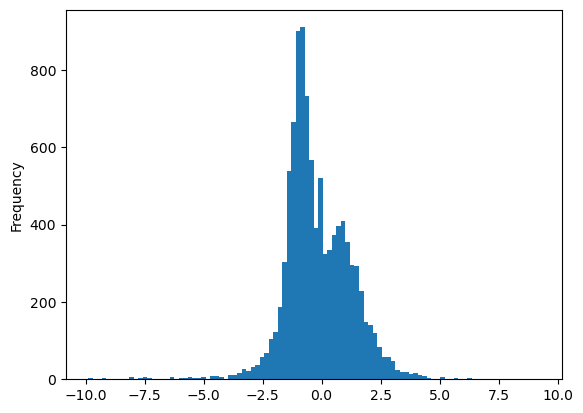

In [32]:
# histogram of start-finish z-scores
df.Start_Finish_Z.plot(kind='hist', bins=100);

CONLIT


Start_Finish_Z  Start_Finish_Miles
count     2377.000000         2377.000000
mean        -0.189067         2044.236805
std          1.462865         2441.418497
min         -9.819165            0.000000
25%         -1.018797           41.850694
50%         -0.474388          952.185312
75%          0.732600         3559.731012
max          9.220580        11268.262827

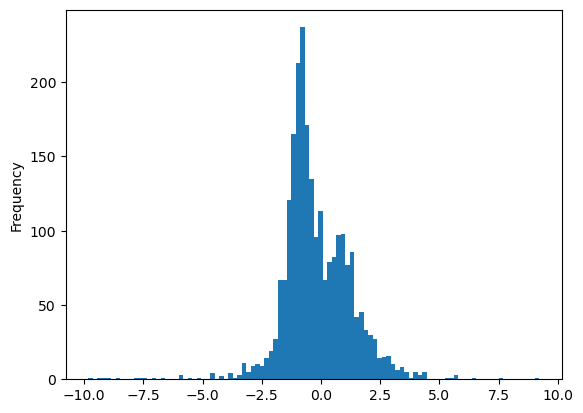

Chicago I


Start_Finish_Z  Start_Finish_Miles
count     1710.000000         1710.000000
mean        -0.211824         2039.759307
std          1.502220         2362.654376
min         -9.745281            0.000000
25%         -1.090967           60.118695
50%         -0.428785          896.094837
75%          0.826317         3695.784248
max          8.056007        11744.534708

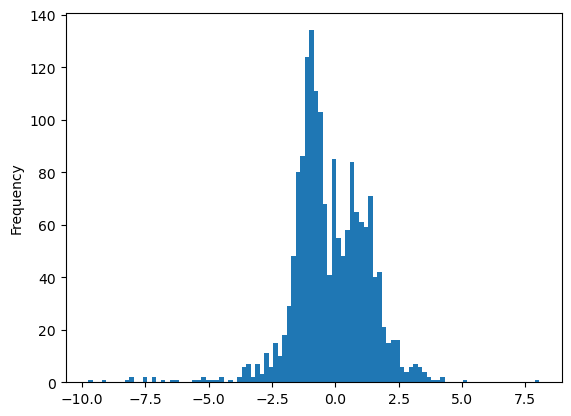

Chicago II


Start_Finish_Z  Start_Finish_Miles
count     5279.000000         5279.000000
mean        -0.189482         1962.562720
std          1.383779         2371.192888
min         -9.876093            0.000000
25%         -1.023525           83.014465
50%         -0.456551          927.852470
75%          0.668035         3396.944678
max          7.092218        11404.438708

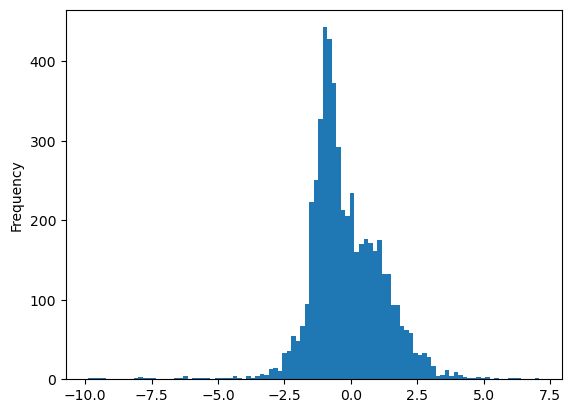

EAF


Start_Finish_Z  Start_Finish_Miles
count      255.000000          255.000000
mean        -0.258029         2012.187267
std          1.687467         2161.983421
min         -8.914441            0.000000
25%         -1.213339          157.014664
50%         -0.446488          951.038795
75%          1.002956         3558.342598
max          4.495445         9918.646973

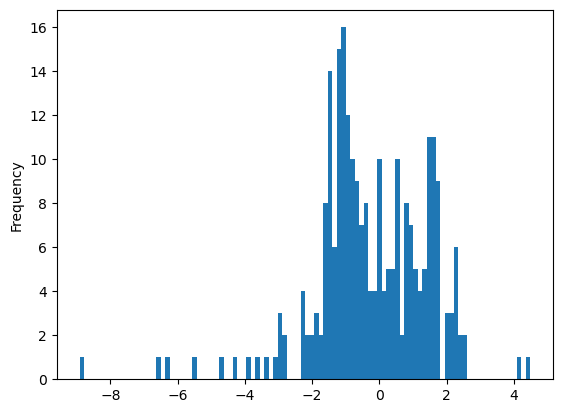

Wright


Start_Finish_Z  Start_Finish_Miles
count      492.000000          492.000000
mean        -0.159545         1971.538587
std          1.621605         2183.066869
min         -8.038939            0.000000
25%         -1.108575          148.741146
50%         -0.419599          893.628831
75%          0.995351         3729.664795
max          6.802899         9517.987399

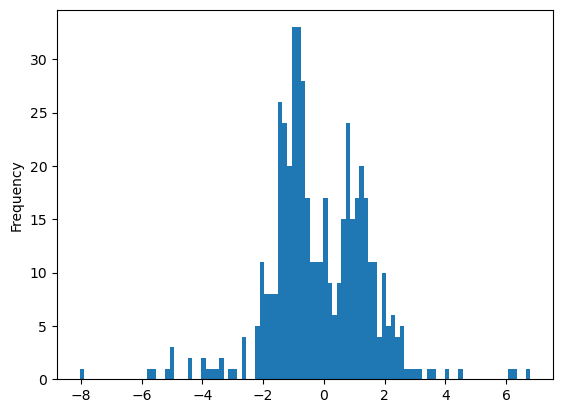

In [33]:
# ditto, by subcorpus

for name, group in df.groupby('collection'):
    print(name)
    display(group.describe())
    group.Start_Finish_Z.plot(kind='hist', bins=100)
    plt.show()

In [34]:
# compare start-finish results by facet
print('======================\n======================\n   *** CONLIT ***\n======================\n======================')
compare_facets(
    df=df.loc[df.collection=='CONLIT'], 
    facets=facet_by,
    cols_to_drop=[],
    statistic=diff_means
)

print('\n\n======================\n======================\n   *** EARLY ***\n======================\n======================')
facet_by = ['inf_gender', 'author_gender', 'perspective']
compare_facets(
    df=df.loc[df.collection!='CONLIT'], 
    facets=facet_by,
    cols_to_drop=[],
    statistic=diff_means
)

   *** CONLIT ***

Facet: Category


FIC          NON       diff         p sig
Start_Finish_Z        -0.203488    -0.159200  -0.044288  0.499000    
Start_Finish_Miles  2073.354119  1983.933118  89.421001  0.387045


Facet: inf_gender


she/her/hers   he/him/his        diff         p sig
Start_Finish_Z         -0.203730    -0.204415    0.000685  0.982807    
Start_Finish_Miles   2136.237556  2028.162184  108.075372  0.395842


Facet: author_gender


F            M        diff         p sig
Start_Finish_Z        -0.172947    -0.239175    0.066228  0.405438    
Start_Finish_Miles  2016.792824  2129.891069 -113.098245  0.354258


Facet: perspective


other        first       diff         p sig
Start_Finish_Z        -0.200348    -0.205833   0.005484  0.952419    
Start_Finish_Miles  2077.982217  2060.084556  17.897661  0.878848


Facet: Genre


YA       others        diff         p sig
Start_Finish_Z        -0.430460    -0.179701   -0.250759  0.063974    
Start_Finish_Miles  1588.701042  2118.249710 -529.548667  0.012795   *

SF       others        diff         p  sig
Start_Finish_Z        -0.098652    -0.215135    0.116483  0.356657     
Start_Finish_Miles  2753.108619  1990.705924  762.402695  0.000800  ***

BS       others        diff         p sig
Start_Finish_Z        -0.263504    -0.193083   -0.070421  0.512595    
Start_Finish_Miles  1891.492370  2098.385703 -206.893334  0.222311

NYT       others       diff         p sig
Start_Finish_Z        -0.175837    -0.211401   0.035565  0.712515    
Start_Finish_Miles  2122.078055  2052.594543  69.483512  0.651739

MY       others        diff         p sig
Start_Finish_Z        -0.119367    -0.215966    0.096599  0.407837    
Start_Finish_Miles  1945.386492  2087.208825 -141.822333  0.443822

ROM       others       diff         p sig
Start_Finish_Z        -0.112365    -0.212730   0.100365  0.440624    
Start_Finish_Miles  2037.896572  2071.729333 -33.832762  0.912435

PW       others        diff         p sig
Start_Finish_Z        -0.092036    -0.221711    0.129674  0.247901    
Start_Finish_Miles  2332.954576  2024.622927  308.331649  0.084766

MID       others        diff         p sig
Start_Finish_Z        -0.566110    -0.179362   -0.386749  0.015994   *
Start_Finish_Miles  1580.952294  2100.622037 -519.669743  0.028788   *



   *** EARLY ***

Facet: inf_gender


she/her/hers   he/him/his        diff         p sig
Start_Finish_Z         -0.221618    -0.183274   -0.038344  0.276689    
Start_Finish_Miles   1889.499753  2021.241024 -131.741271  0.023990   *


Facet: author_gender


M            F       diff         p sig
Start_Finish_Z        -0.185444    -0.213010   0.027565  0.423031    
Start_Finish_Miles  2014.972293  1915.312136  99.660157  0.083966


Facet: perspective


other        first       diff         p sig
Start_Finish_Z        -0.216119    -0.158809  -0.057310  0.105558    
Start_Finish_Miles  1987.303758  1964.200989  23.102768  0.685326

## Examine specific books and authors

In [35]:
# Read metadata
conlit_meta = pd.read_csv(os.path.join(metadata_dir, conlit_meta_file), index_col='ID').fillna('')
early_meta = pd.read_csv(os.path.join(metadata_dir, early_meta_file), index_col='book_id', sep='\t').fillna('')

In [36]:
# reference points
print("Median distance:", data.dist_miles.median())
print("Median numbers GPEs:", data.num_gpe_places.median())

Median distance: 15731.384666142823
Median numbers GPEs: 9.0


In [37]:
# Tolkien
early_meta.loc[early_meta.author.str.startswith('Tolkien'), ['author', 'title']].join(data[['dist_miles', 'num_gpe_places']])

author       title  dist_miles  num_gpe_places
book_id                                                            
00011059  Tolkien, J. R. R.  The Hobbit         0.0               4

In [38]:
# Any Weir, The Martian
data.loc[data.index.str.contains('TheMartian'), ['dist_miles', 'num_gpe_places']]

dist_miles  num_gpe_places
book_id                                                  
2011_Weir,Andy_TheMartian_SF  9412.553779              16

In [39]:
# Kim Stanley Robinson
display(data.loc[data.index.str.contains('Robinson,Kim'), ['dist_miles', 'num_gpe_places']])
display(early_meta.loc[early_meta.author.str.startswith('Robinson, Kim'), ['author', 'title']].join(data[['dist_miles', 'num_gpe_places']]))

dist_miles  num_gpe_places
book_id                                                         
2012_Robinson,KimStanley_2312_SF    80167.045869              29
2013_Robinson,KimStanley_Shaman_SF      0.000000               1

author                    title    dist_miles  \
book_id                                                                  
00024103  Robinson, Kim Stanley               Green mars  19640.685969   
00023417  Robinson, Kim Stanley             Pacific edge  90421.740009   
00022417  Robinson, Kim Stanley  The memory of whiteness  29284.568645   
00022260  Robinson, Kim Stanley           The Wild Shore  51666.671513   
00022956  Robinson, Kim Stanley           The Gold Coast  91512.217820   
00023180  Robinson, Kim Stanley    Escape from Kathmandu  45137.422620   
00024406  Robinson, Kim Stanley                Blue Mars  57549.459250   
00023967  Robinson, Kim Stanley                 Red Mars  26193.381240   

          num_gpe_places  
book_id                   
00024103              24  
00023417              19  
00022417              16  
00022260              21  
00022956              22  
00023180              23  
00024406              26  
00023967              18

In [40]:
# George R. R. Martin
display(early_meta.loc[early_meta.author.str.startswith('Martin, George R'), ['author', 'title']].join(data[['dist_miles', 'num_gpe_places']]))
display(data.loc[data.index.str.contains('Martin,George'), ['dist_miles', 'num_gpe_places']])

author               title     dist_miles  \
book_id                                                            
00024931  Martin, George R. R    A clash of kings       0.000000   
00022101  Martin, George R. R  The Armageddon rag  103221.908609   
00024359  Martin, George R. R   A game of thrones       0.000000   
00021862  Martin, George R. R           Windhaven     666.305945   
00021989  Martin, George R. R         Fevre dream   58895.552655   
00021448  Martin, George R. R  Dying of the light   35423.305181   
00022541  Martin, George R. R        Tuf voyaging    4962.360649   

          num_gpe_places  
book_id                   
00024931              10  
00022101              36  
00024359               4  
00021862              25  
00021989              26  
00021448              15  
00022541              12

dist_miles  num_gpe_places
book_id                                                            
2011_Martin,George_ADancewithDragons_BS         0.0              12